# DSI Project 4 - West Nile Virus Prediction

# Part 3 - Modeling

`Alex | Elliot | Mak | Robby`

In the previous workbook (Part 2 - Prepocessing), we have combined the data from our `train` and `weather` datasets, performed feature selection and engineering, and subsequently modified the datasets into a suitable format for modelling.

In this workbook, we will fit our data into 3 different models:
1. Gradient Boost
2. Adaboost
3. Extreme Gradient Boost

We will then generate predictions on our test data and analyze the results accordingly.

## Contents

- [1. Handling of the data](#1.-Handling-of-the-data)
    - [1.1. Load the modified train data](#1.1.-Load-the-modified-train-data)
- [2. Model Prep using GridSearch with scaling and SMOTE (Gradient Boost, Adaboost and Extreme Gradient Boost)](#2.-Model-Prep-using-GridSearch-with-scaling-and-SMOTE-(Gradient-Boost,-Adaboost-and-Extreme-Gradient-Boost))
    - [2.1. Computing ROC curve](#2.1.-Computing-ROC-curve)
    - [2.2. Examining Feature Importances](#2.2.-Examining-Feature-Importances)
- [3. Misclassification Analysis](#3.-Misclassification-Analysis)
    - [3.1. Misclassification Analysis of the Gradient Boost model](#3.1.-Misclassification-Analysis-of-the-Gradient-Boost-model)
    - [3.2. Misclassification Analysis of the AdaBoost model](#3.2.-Misclassification-Analysis-of-the-AdaBoost-model)
    - [3.3. Misclassification Analysis of the Extreme GradientBoost model](#3.3.-Misclassification-Analysis-of-the-Extreme-GradientBoost-model)
- [4. Production Model: creating a voting ensemble using our 3 models](#4.-Production-Model:-creating-a-voting-ensemble-using-our-3-models)
    - [4.1. Kaggle Scoring](#4.1.-Kaggle-Scoring)
- [5. Overview of Spraying Control Measures](#5.-Overview-of-Spraying-Control-Measures)
    - [5.1. Efficacy of Spraying](#5.1.-Efficacy-of-Spraying)
    - [5.2. Reactionary Control Measures](#5.2.-Reactionary-Control-Measures)
    - [5.3. Proactive Control Measures](#5.3.-Proactive-Control-Measures)
    - [5.4. Reactive vs Proactive approach to vector control](#5.4.-Reactive-vs-Proactive-approach-to-vector-control)
    - [5.5. Historical costs of vector control](#5.5.-Historical-costs-of-vector-control)
- [6. Cost Benefit Analysis & Recommendations](#6.-Cost-Benefit-Analysis-&-Recommendations)
    - [6.1. Human costs of WNV Disease](#6.1.-Human-costs-of-WNV-Disease)
    - [6.2. Annual Cost](#6.2.-Annual-Cost)
    - [6.3. Annual Benefit](#6.3.-Annual-Benefit)
    - [6.4. Recommendations](#6.4.-Recommendations)
- [7. Conclusions](#7.-Conclusions)
- [8. References](#8.-References)

## 1. Handling of the data
[top](#Contents)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
# using imblearn pipeline instead of sklearn pipeline
from imblearn.pipeline import Pipeline, make_pipeline

# import models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# import ensemble for voting classification
from sklearn.ensemble import VotingClassifier

# importing metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, mean_squared_error

# import tree for visualization of the output trees
from xgboost import plot_tree
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image

# to install graphviz - required for xgboost plot_tree
# !pip install graphviz 


In [2]:
# extra step for graphviz to be found
# website reference: https://stackoverflow.com/questions/52472611/how-do-i-make-sure-the-graphviz-executables-are-on-my-systems-path
# please change to your own directory where graphviz is installed
import os
os.environ['PATH'] += os.pathsep + 'C:/Users/robby/anaconda3/Library/bin/graphviz/'

### 1.1. Load the modified train data
[top](#Contents)

The train file was cleaned and combined with the weather information in the previous notebook, and saved as `train_final.csv`.

In [3]:
# read in train_final dataset
train = pd.read_csv('../datasets/train_final.csv')

In [4]:
train

,date,maxtemp,mintemp,avgtemp,dewpoint,wetbulb,stnpressure,avgspeed,daylength,precipitation,maxtemp_roll_7,mintemp_roll_7,avgtemp_roll_7,dewpoint_roll_7,wetbulb_roll_7,stnpressure_roll_7,avgspeed_roll_7,daylength_roll_7,precipitation_roll_7,maxtemp_roll_14,mintemp_roll_14,avgtemp_roll_14,dewpoint_roll_14,wetbulb_roll_14,stnpressure_roll_14,avgspeed_roll_14,daylength_roll_14,precipitation_roll_14,nummosquitos,wnvpresent,species_wnv_species,trap_wnv_traps,month_peak
0,2007-05-29,88,60,75.5,58.5,65.5,29.415,6.95,896.0,0.0,79.857143,56.428571,68.714286,50.928571,58.857143,29.435714,9.328571,892.142857,0.109714,76.714286,51.571429,64.678571,45.357143,54.357143,29.434286,9.682143,886.071429,0.068786,1.0,0.0,1,1,0
1,2007-05-29,88,60,75.5,58.5,65.5,29.415,6.95,896.0,0.0,79.857143,56.428571,68.714286,50.928571,58.857143,29.435714,9.328571,892.142857,0.109714,76.714286,51.571429,64.678571,45.357143,54.357143,29.434286,9.682143,886.071429,0.068786,1.0,0.0,1,1,0
2,2007-05-29,88,60,75.5,58.5,65.5,29.415,6.95,896.0,0.0,79.857143,56.428571,68.714286,50.928571,58.857143,29.435714,9.328571,892.142857,0.109714,76.714286,51.571429,64.678571,45.357143,54.357143,29.434286,9.682143,886.071429,0.068786,1.0,0.0,1,0,0
3,2007-05-29,88,60,75.5,58.5,65.5,29.415,6.95,896.0,0.0,79.857143,56.428571,68.714286,50.928571,58.857143,29.435714,9.328571,892.142857,0.109714,76.714286,51.571429,64.678571,45.357143,54.357143,29.434286,9.682143,886.071429,0.068786,1.0,0.0,1,1,0
4,2007-05-29,88,60,75.5,58.5,65.5,29.415,6.95,896.0,0.0,79.857143,56.428571,68.714286,50.928571,58.857143,29.435714,9.328571,892.142857,0.109714,76.714286,51.571429,64.678571,45.357143,54.357143,29.434286,9.682143,886.071429,0.068786,4.0,0.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8183,2013-09-26,75,50,64.0,52.0,58.0,29.370,4.40,719.0,0.0,73.571429,50.571429,61.357143,50.142857,55.428571,29.277857,7.607143,727.571429,0.002071,72.642857,52.714286,62.785714,50.892857,56.285714,29.341429,8.296429,737.928571,0.101500,1.0,0.0,1,1,1
8184,2013-09-26,75,50,64.0,52.0,58.0,29.370,4.40,719.0,0.0,73.571429,50.571429,61.357143,50.142857,55.428571,29.277857,7.607143,727.571429,0.002071,72.642857,52.714286,62.785714,50.892857,56.285714,29.341429,8.296429,737.928571,0.101500,5.0,0.0,1,1,1
8185,2013-09-26,75,50,64.0,52.0,58.0,29.370,4.40,719.0,0.0,73.571429,50.571429,61.357143,50.142857,55.428571,29.277857,7.607143,727.571429,0.002071,72.642857,52.714286,62.785714,50.892857,56.285714,29.341429,8.296429,737.928571,0.101500,1.0,0.0,1,1,1
8186,2013-09-26,75,50,64.0,52.0,58.0,29.370,4.40,719.0,0.0,73.571429,50.571429,61.357143,50.142857,55.428571,29.277857,7.607143,727.571429,0.002071,72.642857,52.714286,62.785714,50.892857,56.285714,29.341429,8.296429,737.928571,0.101500,37.0,0.0,1,1,1


In [5]:
# define our X and target variables
X = train.drop(['date', 'wnvpresent', 'nummosquitos'],
               axis=1)
y = train['wnvpresent']

In [6]:
# read in test_final and prep the dataset
test_df = pd.read_csv('../datasets/test_final.csv')

In [7]:
id_series = test_df['id'] 

test_df.drop(['Date', 'id'], axis=1, inplace=True)

**Baseline Accuracy**

In [8]:
y.value_counts(normalize=True)

0.0    0.949927
1.0    0.050073
Name: wnvpresent, dtype: float64

It is clear from here that wnvpresent (positive WNV occurrence, or `1`) is the minority class (approx. 5%), and using the typical accuracy metric would not be desirable. For instance, we could simply predict that all traps have no WNV occurrences (`0`), which will naturally give us a 95% accuracy without doing any predictive analytics. Such a model would not be useful in predicting which of the traps have a high possibility of positive WNV occurence.<br>

In cases of such an imbalanced distribution of the target variable, **AUC-ROC** (Area Under Curve - Receiver Operating Characteristic) scoring is preferred. The ROC curve summarizes the trade-off between the True Positive Rate (TPR) and False Positive Rate (FPR) for a classification model using different probability thresholds, and the AUC represents the degree or measure of separability. Essentially, it measures how much the model is capable of distinguishing between classes. Hence, the higher the AUC, the model is better at predicting 0s as 0s and 1s as 1s. In our case, a higher AUC-ROC score will be better at predicting and discriminating wnv rates in traps.

A second classification metric we would be focusing on is the **recall** score, which is calculated as the number of true positives divided by the total number of true positives and false negatives. Given the potentially high costs to human health, it is desirable to reduce the number of false negatives as we would want to minimize instances where we miss out on detecting WNV positive cases.
<br>

**Train Validation Split**

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=42)

## 2. Model Prep using GridSearch with scaling and SMOTE (Gradient Boost, Adaboost and Extreme Gradient Boost)
[top](#Contents)

In our GridSearch across several models, we found that the boosting models, in particular - gradient boost, adaboost and extreme gradient boost models - consistently gave better scores (around AUC = 0.84), compared to other classification models such as `LogisticRegression` or `MultinomialBayes`. Hence, we made the decision to concentrate on the boosting models.

In [10]:
# Focusing just on boosting models

pipe_1 = Pipeline([
    ('scale', StandardScaler()),
    ('sampling', SMOTE(random_state=42)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

pipe_2 = Pipeline([
    ('scale', StandardScaler()),
    ('sampling', SMOTE(random_state=42)),
    ('ada', AdaBoostClassifier(random_state=42))
])

pipe_3 = Pipeline([
    ('scale', StandardScaler()),
    ('sampling', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(random_state=42))
])


In [11]:
# setting the parameters for each pipe

pipe_1_params = {
    'sampling__sampling_strategy': [0.9], #0.9
    'sampling__k_neighbors': [10], #10
    'gboost__loss': ['exponential'],
    'gboost__learning_rate': [0.2], # 0.2
    'gboost__n_estimators': [120], #120
    'gboost__max_depth': [4] #4
}

pipe_2_params = {
    'sampling__sampling_strategy': [0.65, 0.8], #0.65
    'sampling__k_neighbors': [7, 9, 11, 13],  #9
    'ada__learning_rate': [0.65, 0.7], #0.65
    'ada__n_estimators': [125, 150], #150 
}

pipe_3_params = {
    'sampling__sampling_strategy': [0.85], #0.85
    'sampling__k_neighbors': [4], #4
    'xgb__eval_metric': ['auc'],
    'xgb__learning_rate': [0.12, 0.14, 0.2], #0.14
    'xgb__min_child_weight': [3], #3
    'xgb__max_depth': [4], #4
    'xgb__max_delta_step': [8], #8
    'xgb__n_estimators': [200, 250],  #200
    'xgb__colsample_bytree' : [0.65], #0.65
    'xgb__subsample' : [0.6], #0.6
    'xgb__reg_alpha' : [0.09], #0.09
    'xgb__reg_lambda' : [3], #3
    'xgb__gamma' : [0.04, 0.05], #0.04
}


In [12]:
# setting up the grid searches

gs_1 = GridSearchCV(estimator = pipe_1,
                    param_grid = pipe_1_params,
                    cv = 5,
                    scoring='roc_auc',
                    verbose = 1,
                    n_jobs=-1)

gs_2 = GridSearchCV(estimator = pipe_2,
                    param_grid = pipe_2_params,
                    cv = 5,
                    scoring='roc_auc',
                    verbose = 1,
                    n_jobs=-1)

gs_3 = GridSearchCV(estimator = pipe_3,
                    param_grid = pipe_3_params,
                    cv = 5,
                    scoring='roc_auc',
                    verbose = 1,
                    n_jobs=-1)



In [13]:
grids = [gs_1, gs_2, gs_3]

grid_dict = {0: 'Gradient Boosting', 1: 'Ada Boosting', 
             2: 'Extreme Gradient Boost'}

In [14]:
for idx, gs in enumerate(grids):
    print('---------------Starting GridSearch--------------------------------')
    print(f'\nGridsearch on Estimator: {grid_dict[idx]}')
    
    # Fit grid search
    gs.fit(X_train, y_train)
    
    # showing best params
    print(f'Best params: {gs.best_params_}')
    
    # Best training score
    print(f'Best GridSearchCV AUC: {round(gs.best_score_, 3)}')
    
    model = gs.best_estimator_
    
    y_train_pred = model.predict_proba(X_train)[:,1]
    y_val_pred = model.predict_proba(X_val)[:,1]
    
    
    # Scoring on validation data with best params
    print(f'Training AUC on best params: {round(roc_auc_score(y_train, y_train_pred), 3)}')
    
    print(f'Validation AUC on best params: {round(roc_auc_score(y_val, y_val_pred), 3)}')
    
    # Printing Confusion Matrix and Scoring reports
    print()
    print(f'Confusion Matrix for: {grid_dict[idx]}')
    print(confusion_matrix(y_val, gs.predict(X_val)))
    print()
    print(f'Scoring Report for: {grid_dict[idx]}')
    print(classification_report(y_val, gs.predict(X_val)))
    

---------------Starting GridSearch--------------------------------

Gridsearch on Estimator: Gradient Boosting
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished


Best params: {'gboost__learning_rate': 0.2, 'gboost__loss': 'exponential', 'gboost__max_depth': 4, 'gboost__n_estimators': 120, 'sampling__k_neighbors': 10, 'sampling__sampling_strategy': 0.9}
Best GridSearchCV AUC: 0.839
Training AUC on best params: 0.871
Validation AUC on best params: 0.861

Confusion Matrix for: Gradient Boosting
[[1916  418]
 [  34   89]]

Scoring Report for: Gradient Boosting
              precision    recall  f1-score   support

         0.0       0.98      0.82      0.89      2334
         1.0       0.18      0.72      0.28       123

    accuracy                           0.82      2457
   macro avg       0.58      0.77      0.59      2457
weighted avg       0.94      0.82      0.86      2457

---------------Starting GridSearch--------------------------------

Gridsearch on Estimator: Ada Boosting
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.2min finished


Best params: {'ada__learning_rate': 0.65, 'ada__n_estimators': 125, 'sampling__k_neighbors': 13, 'sampling__sampling_strategy': 0.65}
Best GridSearchCV AUC: 0.834
Training AUC on best params: 0.869
Validation AUC on best params: 0.872

Confusion Matrix for: Ada Boosting
[[2020  314]
 [  43   80]]

Scoring Report for: Ada Boosting
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92      2334
         1.0       0.20      0.65      0.31       123

    accuracy                           0.85      2457
   macro avg       0.59      0.76      0.61      2457
weighted avg       0.94      0.85      0.89      2457

---------------Starting GridSearch--------------------------------

Gridsearch on Estimator: Extreme Gradient Boost
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   31.6s finished
C:\Users\robby\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best params: {'sampling__k_neighbors': 4, 'sampling__sampling_strategy': 0.85, 'xgb__colsample_bytree': 0.65, 'xgb__eval_metric': 'auc', 'xgb__gamma': 0.04, 'xgb__learning_rate': 0.14, 'xgb__max_delta_step': 8, 'xgb__max_depth': 4, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 200, 'xgb__reg_alpha': 0.09, 'xgb__reg_lambda': 3, 'xgb__subsample': 0.6}
Best GridSearchCV AUC: 0.838
Training AUC on best params: 0.872
Validation AUC on best params: 0.864

Confusion Matrix for: Extreme Gradient Boost
[[1827  507]
 [  29   94]]

Scoring Report for: Extreme Gradient Boost
              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87      2334
         1.0       0.16      0.76      0.26       123

    accuracy                           0.78      2457
   macro avg       0.57      0.77      0.57      2457
weighted avg       0.94      0.78      0.84      2457



### 2.1. Computing ROC curve
[top](#Contents)

We observe that our boosting models mostly have an AUC-ROC score of about 0.84 to 0.86. 
A plot of the ROC curves allows us to observe visually and compare their individual curves:

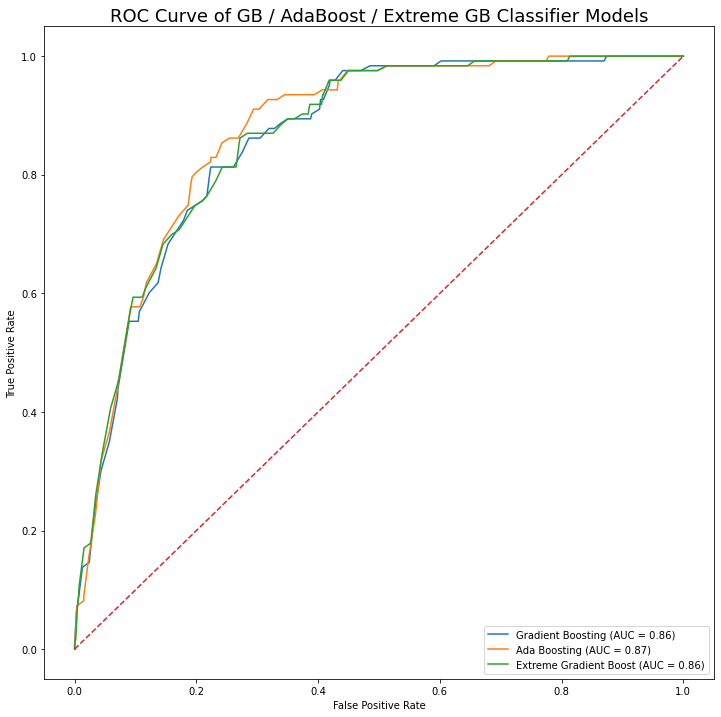

In [15]:
figure = plt.figure(figsize=(12,12))
ax = plt.gca()
Gboost_plot = plot_roc_curve(gs_1, X_val, y_val, name=grid_dict[0], ax=ax)
Adaboost_plot = plot_roc_curve(gs_2, X_val, y_val, name=grid_dict[1], ax=ax)
Xgb_plot = plot_roc_curve(gs_3, X_val, y_val, name=grid_dict[2], ax=ax)
ax.plot(np.linspace(0, 1, 200),
        np.linspace(0, 1, 200),
        linestyle='--')
plt.title('ROC Curve of GB / AdaBoost / Extreme GB Classifier Models', fontsize=18)
plt.show()


A ROC curve is constructed by plotting the true positive rate (TPR) against the false positive rate (FPR). The true positive rate is the proportion of observations that were correctly predicted to be positive out of all positive observations (TP/(TP + FN)). Similarly, the false positive rate is the proportion of observations that are incorrectly predicted to be positive out of all negative observations (FP/(TN + FP)). 

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR). The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

From our chart, we see that the 3 models have very similar ROC curves, making it difficult to determine if one model is truly better than the others. Hence, we decided to use a voting classifier as our final production model, using these 3 models as inputs into the voting classifier. 

Before we proceed, let's examine the feature importances for each model:

### 2.2. Examining Feature Importances
[top](#Contents)

In [16]:
features = X.columns

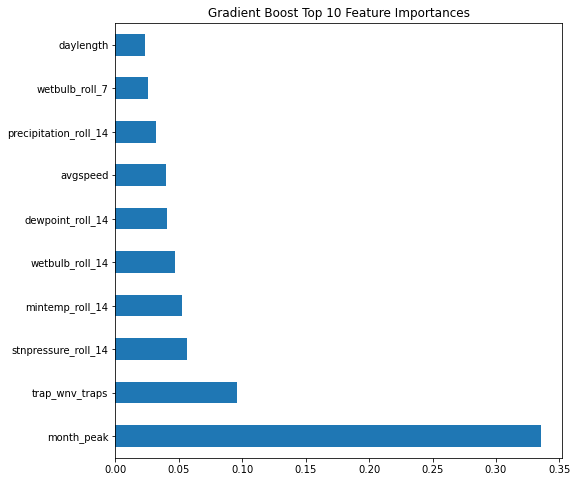

In [17]:
# access the feature importances from the gridsearch
feat_imp = gs_1.best_estimator_.named_steps['gboost'].feature_importances_
# tag with feature name and sort from most important to least
gb_feat_imp = pd.Series(feat_imp, features).sort_values(ascending=False)
# getting the top 10 features
gb_top10 = gb_feat_imp[:10]
# plot top 10 features
plt.figure(figsize=(8,8))
gb_top10.plot(kind='barh', title='Gradient Boost Top 10 Feature Importances')
plt.show();

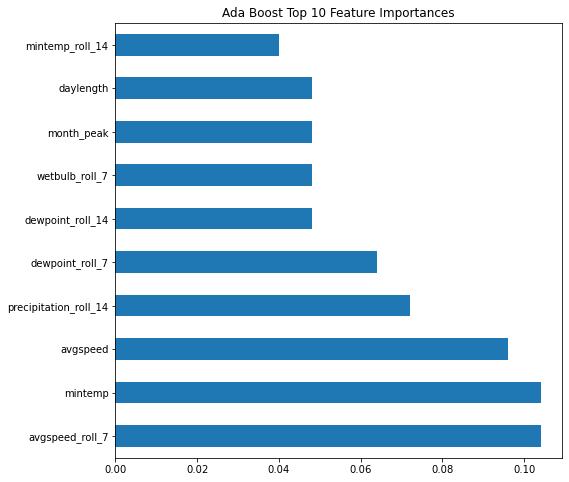

In [18]:
# access the feature importances from the gridsearch
feat_imp = gs_2.best_estimator_.named_steps['ada'].feature_importances_
# tag with feature name and sort from most important to least
ada_feat_imp = pd.Series(feat_imp, features).sort_values(ascending=False)
# getting the top 10 features
ada_top10 = ada_feat_imp[:10]
# plot top 10 features
plt.figure(figsize=(8,8))
ada_top10.plot(kind='barh', title='Ada Boost Top 10 Feature Importances')
plt.show();

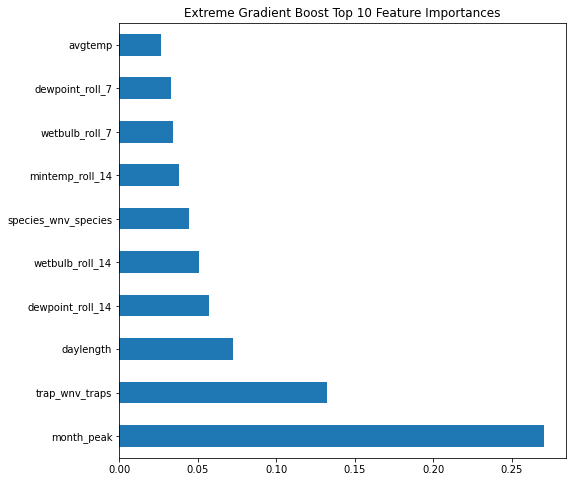

In [19]:
# access the feature importances from the gridsearch
feat_imp = gs_3.best_estimator_.named_steps['xgb'].feature_importances_
# tag with feature name and sort from most important to least
xgb_feat_imp = pd.Series(feat_imp, features).sort_values(ascending=False)
# getting the top 10 features
xgb_top10 = xgb_feat_imp[:10]
# plot top 10 features
plt.figure(figsize=(8,8))
xgb_top10.plot(kind='barh', title='Extreme Gradient Boost Top 10 Feature Importances')
plt.show();

From the above graphs indicating the top 10 feature importances for each model, we see that each model yielded a slightly different combination of features, although there are common features across the models. 

For example, in GradientBoost model, the peak months (Aug and Sep) were the most important given that we saw the highest wnv rates usually in August and September. The next was the trap feature, indicating which were the traps that historically had wnv rates previously. WNV Mosquito species were not featured in the top 10 which was surprising to us, instead 7-day and 14-day rolling weather data predominantly make up the rest of the top 10 features.
<br>

On the other hand, our Adaboost model took more importance from the weather features with temperature type features - mintemp (1st), avgtemp (10th), and wind speed also had higher importance with 7-day avgspeed and avgspeed having the second and third most importance respectively in the model. This also made sense from the literature review we had conducted, which noted that mosquitoes tended not to be as active on days when winds were strong. It is worth noting that our peak month feature was only the 6th most important feature in the Adaboost model. 
<br>

Lastly, for our Extreme GradientBoost model, the peak months (1st) and traps (2nd) were more important. Interestingly, wnv mosquito species (6th) was considered even though it was ignored by both the GradientBoost and AdaBoost models, a feature we had expected to be in the top 10 features on all 3 models. 
<br>

It is worth noting that although there are a high number of similar features in the top 10 features, the magnitude (and ranking) of these features differ. Furthermore, Extreme GradientBoost model considered the wnv mosquito species to be one of the top features, which was missing from the other 2 models. Additionally, since their AUC-ROC are largely simliar, with no clear dominant model, we propose to proceed with building a voting classifier based on these 3 models for our final production model.

## 3. Misclassification Analysis
[top](#Contents)

We examine mis-classified traps for each of our models and try to have a broad overview of where the model fails in predicting traps with actual wnv rates (false negatives) since the cost of these are much higher than the false positives. 
<br>

Our comparison method is to compare the characteristics of the set of all actual positives in the validation set with the characteristics of the predicted positives from each of our 3 models. Intuitively, since our 3 models are tree-based models, they should show very similar characteristics if the splits were done effectively. Additionally, we chose the interquartile range (first-quartile, median, third-quartile) as our comparative descriptive statistics to capture the middle 50% of the respective subset to show broadly how and where they differ and the areas where they are similar:

In [20]:
# extract the predictions and the probabilities from each model
gb_predict = gs_1.best_estimator_.predict(X_val)
gb_proba_wnv = gs_1.best_estimator_.predict_proba(X_val)[:,1]

ab_predict = gs_2.best_estimator_.predict(X_val)
ab_proba_wnv = gs_2.best_estimator_.predict_proba(X_val)[:,1]

xgb_predict = gs_3.best_estimator_.predict(X_val)
xgb_proba_wnv = gs_3.best_estimator_.predict_proba(X_val)[:,1]


In [21]:
# create a copy of X_val and insert the actual label (y_val), predictions and probabilities 
misclass_df = X_val.copy()
# append predictions and probabilities from our 3 models
misclass_df['wnv_present'] = y_val
misclass_df['gb_wnv'] = gb_predict
misclass_df['gb_probs'] = gb_proba_wnv
misclass_df['ab_wnv'] = ab_predict
misclass_df['ab_probs'] = ab_proba_wnv
misclass_df['xgb_wnv'] = xgb_predict
misclass_df['xgb_probs'] = xgb_proba_wnv

In [22]:
# specify df of wnv_present = 1 only (df of all actual positives)
act_positives = misclass_df.loc[misclass_df['wnv_present']==1]
# get the overall description of the actual positives set
act_positives_des = act_positives.describe()
# specify the median, 1st quartile and 3rd quartile of this df
act_positives_median = pd.Series(act_positives_des.loc['50%'], name='act_post_median')
act_positives_1stQrt = pd.Series(act_positives_des.loc['25%'], name='act_post_1stQrt')
act_positives_3rdQrt = pd.Series(act_positives_des.loc['75%'], name='act_post_3rdQrt')

In [23]:
compare_misclass = pd.concat([act_positives_1stQrt, act_positives_median], axis=1)
compare_misclass['act_post_3rdQrt'] = act_positives_3rdQrt
compare_misclass  # check

,act_post_1stQrt,act_post_median,act_post_3rdQrt
maxtemp,81.000000,86.000000,90.000000
mintemp,63.000000,69.000000,71.000000
avgtemp,73.000000,76.500000,79.500000
dewpoint,57.250000,64.500000,68.500000
wetbulb,63.750000,69.000000,71.750000
stnpressure,29.205000,29.260000,29.315000
avgspeed,6.000000,6.450000,8.900000
daylength,790.000000,820.000000,851.000000
precipitation,0.000000,0.000000,0.274000
maxtemp_roll_7,80.428571,83.000000,84.857143


In [24]:
# create df of predicted positives for GradientBoost model
gb_positives = misclass_df.loc[misclass_df['gb_wnv']==1]
# get the overall description of the gb predicted positives set
gb_positives_des = gb_positives.describe()

# specify the median, 1st quartile and 3rd quartile of this df
# append to compare_misclass df
compare_misclass['gb_post_1stQrt'] = pd.Series(gb_positives_des.loc['25%'])
compare_misclass['gb_post_median'] = pd.Series(gb_positives_des.loc['50%'])
compare_misclass['gb_post_3rdQrt'] = pd.Series(gb_positives_des.loc['75%'])

In [25]:
# create df of predicted positives for AdaBoost model
ab_positives = misclass_df.loc[misclass_df['ab_wnv']==1]
# get the overall description of the gb predicted positives set
ab_positives_des = ab_positives.describe()

# specify the median, 1st quartile and 3rd quartile of this df
# append to compare_misclass df
compare_misclass['ab_post_1stQrt'] = pd.Series(ab_positives_des.loc['25%'])
compare_misclass['ab_post_median'] = pd.Series(ab_positives_des.loc['50%'])
compare_misclass['ab_post_3rdQrt'] = pd.Series(ab_positives_des.loc['75%'])

In [26]:
# create df of predicted positives for Extreme GradientBoost model
xgb_positives = misclass_df.loc[misclass_df['xgb_wnv']==1]
# get the overall description of the gb predicted positives set
xgb_positives_des = xgb_positives.describe()

# specify the median, 1st quartile and 3rd quartile of this df
# append to compare_misclass df
compare_misclass['xgb_post_1stQrt'] = pd.Series(xgb_positives_des.loc['25%'])
compare_misclass['xgb_post_median'] = pd.Series(xgb_positives_des.loc['50%'])
compare_misclass['xgb_post_3rdQrt'] = pd.Series(xgb_positives_des.loc['75%'])

In [27]:
compare_misclass #check

,act_post_1stQrt,act_post_median,act_post_3rdQrt,gb_post_1stQrt,gb_post_median,gb_post_3rdQrt,ab_post_1stQrt,ab_post_median,ab_post_3rdQrt,xgb_post_1stQrt,xgb_post_median,xgb_post_3rdQrt
maxtemp,81.000000,86.000000,90.000000,81.000000,86.000000,92.000000,81.000000,83.000000,86.000000,81.000000,84.000000,90.000000
mintemp,63.000000,69.000000,71.000000,65.000000,69.000000,71.000000,61.000000,66.000000,69.000000,62.000000,69.000000,69.000000
avgtemp,73.000000,76.500000,79.500000,73.000000,77.000000,80.500000,73.000000,75.000000,77.000000,73.000000,76.500000,80.000000
dewpoint,57.250000,64.500000,68.500000,58.500000,64.500000,68.000000,56.500000,64.500000,68.000000,56.500000,62.500000,68.000000
wetbulb,63.750000,69.000000,71.750000,64.000000,69.500000,70.500000,63.500000,69.000000,70.500000,63.500000,69.000000,70.500000
stnpressure,29.205000,29.260000,29.315000,29.175000,29.260000,29.315000,29.200000,29.260000,29.310000,29.200000,29.260000,29.315000
avgspeed,6.000000,6.450000,8.900000,6.000000,7.200000,9.600000,6.450000,7.200000,9.600000,6.000000,7.200000,9.600000
daylength,790.000000,820.000000,851.000000,798.000000,835.000000,866.000000,780.000000,817.000000,835.000000,780.000000,835.000000,866.000000
precipitation,0.000000,0.000000,0.274000,0.000000,0.008500,0.423000,0.000000,0.008500,0.423000,0.000000,0.003500,0.293000
maxtemp_roll_7,80.428571,83.000000,84.857143,80.428571,83.857143,86.285714,77.285714,80.428571,84.857143,77.285714,82.857143,86.285714


### 3.1. Misclassification Analysis of the Gradient Boost model
[top](#Contents)

In [28]:
misclass_df

,maxtemp,mintemp,avgtemp,dewpoint,wetbulb,stnpressure,avgspeed,daylength,precipitation,maxtemp_roll_7,mintemp_roll_7,avgtemp_roll_7,dewpoint_roll_7,wetbulb_roll_7,stnpressure_roll_7,avgspeed_roll_7,daylength_roll_7,precipitation_roll_7,maxtemp_roll_14,mintemp_roll_14,avgtemp_roll_14,dewpoint_roll_14,wetbulb_roll_14,stnpressure_roll_14,avgspeed_roll_14,daylength_roll_14,precipitation_roll_14,species_wnv_species,trap_wnv_traps,month_peak,wnv_present,gb_wnv,gb_probs,ab_wnv,ab_probs,xgb_wnv,xgb_probs
13,88,60,75.5,58.5,65.5,29.415,6.95,896.0,0.00,79.857143,56.428571,68.714286,50.928571,58.857143,29.435714,9.328571,892.142857,0.109714,76.714286,51.571429,64.678571,45.357143,54.357143,29.434286,9.682143,886.071429,0.068786,1,1,0,0.0,0.0,6.188370e-05,0.0,0.421834,0.0,0.005920
1884,81,69,75.0,67.0,69.0,29.135,7.20,811.0,0.22,80.428571,66.428571,73.428571,65.928571,68.071429,29.245714,7.621429,819.428571,0.755500,81.642857,66.071429,74.178571,64.428571,67.821429,29.289286,7.021429,828.214286,0.464893,1,1,1,1.0,1.0,8.120786e-01,1.0,0.503587,1.0,0.786115
3954,74,64,70.0,59.0,63.0,29.385,7.50,853.0,0.28,80.142857,62.428571,71.928571,56.857143,62.857143,29.276429,7.950000,859.857143,0.050643,81.214286,62.500000,72.535714,57.142857,63.285714,29.215000,8.117857,867.357143,0.028536,1,1,1,0.0,0.0,2.108166e-03,0.0,0.491438,0.0,0.014833
4419,72,50,62.0,51.5,56.5,29.480,4.80,745.0,0.00,78.571429,58.000000,68.785714,56.214286,61.214286,29.439286,5.892857,754.571429,0.000714,78.142857,58.785714,69.214286,57.785714,62.178571,29.450357,6.014286,764.357143,0.001464,1,1,1,0.0,0.0,6.084561e-04,0.0,0.486425,0.0,0.005634
5812,87,64,76.5,62.5,68.0,29.205,5.50,825.0,0.00,83.000000,62.142857,73.285714,60.142857,65.142857,29.270000,6.385714,832.142857,0.121143,82.571429,63.214286,73.535714,61.000000,65.785714,29.200357,6.592857,840.428571,0.169143,1,1,1,0.0,0.0,2.203750e-02,0.0,0.492111,0.0,0.042343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2527,91,68,80.0,62.5,68.5,29.305,11.20,725.0,0.00,84.285714,60.142857,73.071429,55.857143,62.928571,29.378571,9.271429,733.142857,0.000000,77.714286,53.357143,66.285714,48.750000,56.785714,29.390357,9.371429,743.857143,0.000214,1,0,1,0.0,0.0,5.724574e-07,0.0,0.353716,0.0,0.000174
6007,94,71,83.0,70.5,75.0,29.230,6.10,790.0,0.00,83.285714,62.857143,73.428571,60.214286,65.357143,29.277857,6.500000,798.142857,0.008000,83.000000,63.428571,73.714286,61.035714,65.785714,29.248214,6.760714,807.500000,0.095750,1,1,1,0.0,0.0,4.079859e-02,0.0,0.497289,0.0,0.089025
2863,61,48,55.0,46.5,50.5,29.390,8.60,901.0,0.09,72.714286,50.428571,62.071429,49.571429,54.857143,29.176429,7.728571,897.714286,0.106143,74.500000,52.785714,64.035714,48.535714,55.214286,29.263929,8.850000,892.571429,0.168857,1,1,0,0.0,0.0,6.857174e-06,0.0,0.410203,0.0,0.001681
4774,82,60,72.0,60.0,64.5,29.155,6.40,913.0,0.00,73.285714,55.285714,64.785714,52.714286,58.000000,29.235000,8.250000,911.714286,0.131429,79.714286,58.071429,69.428571,56.321429,61.535714,29.243929,8.821429,909.428571,0.266286,1,1,0,0.0,0.0,3.576829e-05,0.0,0.419429,0.0,0.001395


In [29]:
# looking at the actual wnv but predicted by GB model as not-wnv group
# we see some are actually predicted to by wnv by other models
misclass_df.iloc[:,-7:].loc[(misclass_df['wnv_present'] == 1) & (misclass_df['gb_wnv'] == 0)]

,wnv_present,gb_wnv,gb_probs,ab_wnv,ab_probs,xgb_wnv,xgb_probs
6073,1.0,0.0,0.046084,0.0,0.492585,0.0,0.105449
2011,1.0,0.0,0.289691,0.0,0.499003,0.0,0.388058
5532,1.0,0.0,0.241363,0.0,0.496858,0.0,0.472037
6023,1.0,0.0,0.040799,0.0,0.497289,0.0,0.089025
977,1.0,0.0,0.145950,0.0,0.498023,0.0,0.213391
5994,1.0,0.0,0.040799,0.0,0.497289,0.0,0.089025
6059,1.0,0.0,0.046084,0.0,0.492585,0.0,0.105449
4161,1.0,0.0,0.476905,1.0,0.501122,1.0,0.711918
5717,1.0,0.0,0.236128,0.0,0.496746,0.0,0.467158
2094,1.0,0.0,0.173896,0.0,0.495992,0.0,0.256429


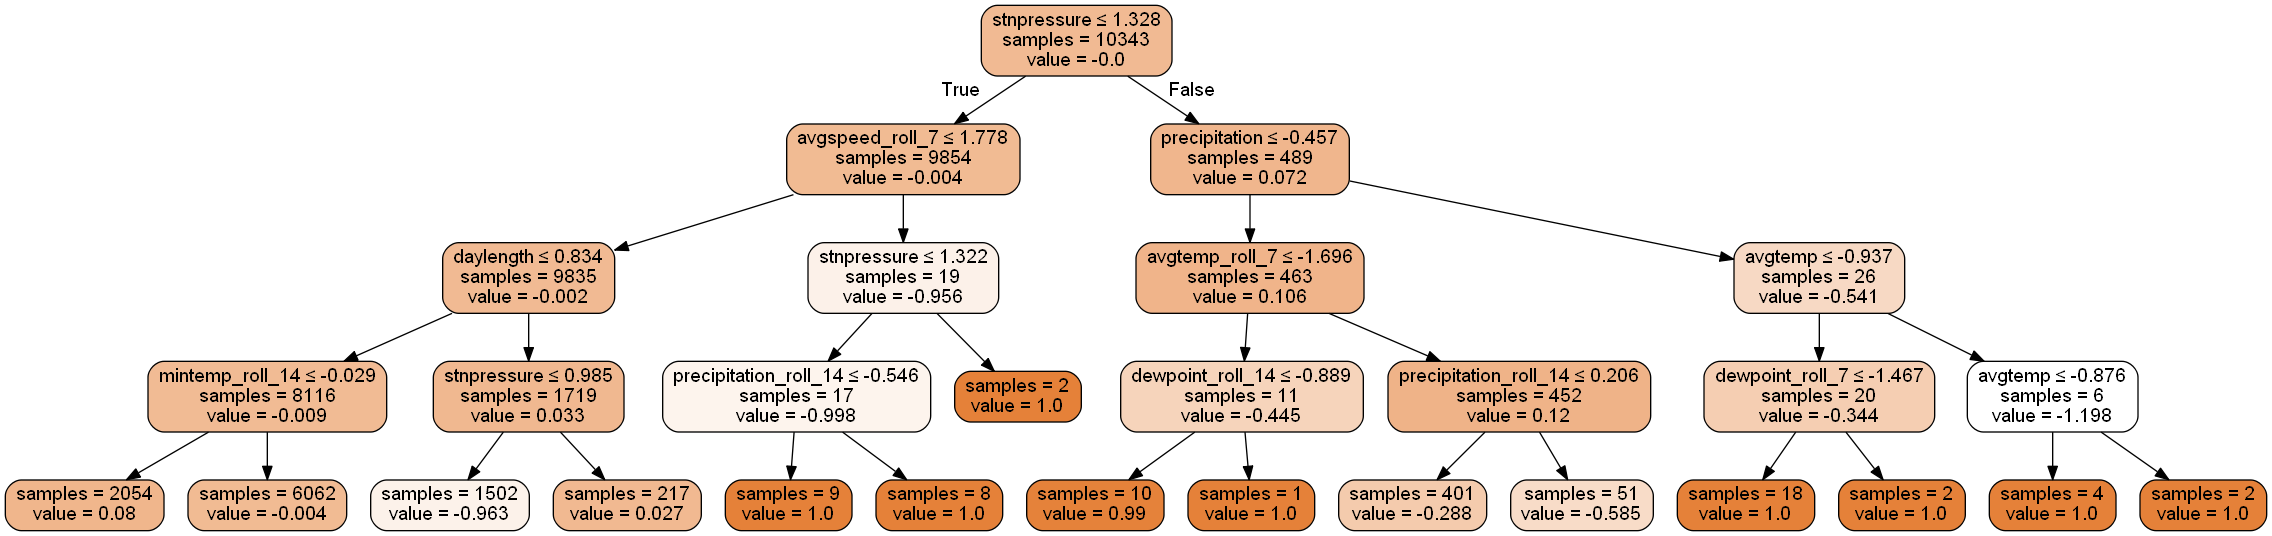

In [30]:
# plotting a particular tree diagram as an example of how the splits were done
sub_tree = gs_1.best_estimator_.named_steps['gboost'].estimators_[37,0]  # tree no. 37 selected

dot_data = export_graphviz(
    sub_tree,
    out_file=None, filled=True, rounded=True,
    special_characters=True, feature_names=features,
    proportion=False, impurity=False,
)
graph = graph_from_dot_data(dot_data)
Image(graph.create_png(), width=1000, height = 900)

In [31]:
# looking at characteristics of actual positives and predicted positives from GradientBoost model
# based on top10 features of our GradientBoost model
gb_top10_feature_names = gb_top10.index.tolist()
compare_misclass.loc[gb_top10_feature_names].iloc[:, :6]

,act_post_1stQrt,act_post_median,act_post_3rdQrt,gb_post_1stQrt,gb_post_median,gb_post_3rdQrt
month_peak,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
trap_wnv_traps,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
stnpressure_roll_14,29.253571,29.291429,29.341071,29.261786,29.289286,29.341071
mintemp_roll_14,63.214286,64.500000,67.357143,63.000000,64.500000,67.714286
wetbulb_roll_14,65.428571,67.000000,68.821429,65.000000,66.964286,68.821429
dewpoint_roll_14,60.107143,62.000000,64.750000,59.107143,62.000000,64.678571
avgspeed,6.000000,6.450000,8.900000,6.000000,7.200000,9.600000
precipitation_roll_14,0.072429,0.134357,0.258214,0.065607,0.083357,0.258214
wetbulb_roll_7,63.928571,66.500000,68.785714,64.357143,67.428571,69.857143
daylength,790.000000,820.000000,851.000000,798.000000,835.000000,866.000000


Looking at just the top10 important features, the IQR characteristics were mainly similar except for:
- avgspeed: actual IQR = (25% = 6, 50% = 6.45, 75% = 8.9) whereas predicted IQR = (6, 7.2, 9.6) with the predictions' IQR distribution included datapoints with higher avgspeed
<br>

- precipitation_roll_14: actual IQR = (0.072, 0.134, 0.258) whereas predicted IQR = (0.066, 0.083, 0.258) with the predictions' IQR distribution included datapoints with lower 14-day rolling average precipitation
<br>

- wetbulb_roll_7: the predictions' IQR distribution shifted rightwards compared to the actual IQR distribution
<br>

- daylength: similarly, the predictions' IQR distribution shifted rightwards compared to the actual IQR distribution

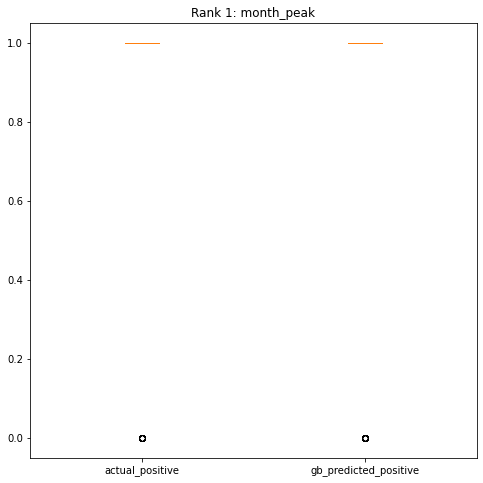

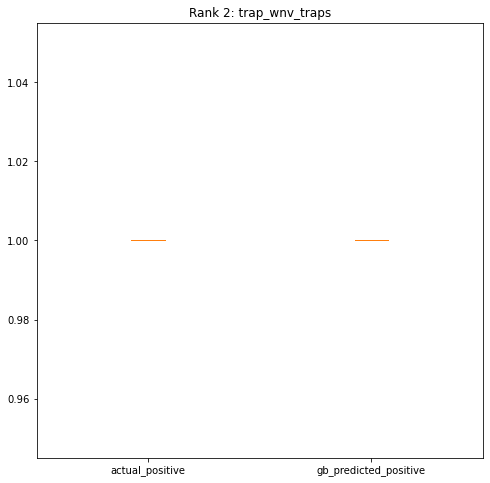

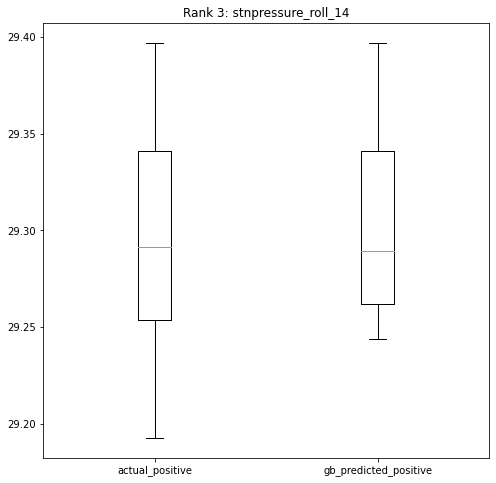

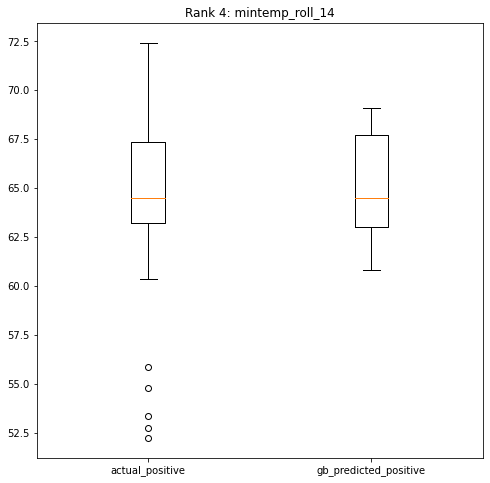

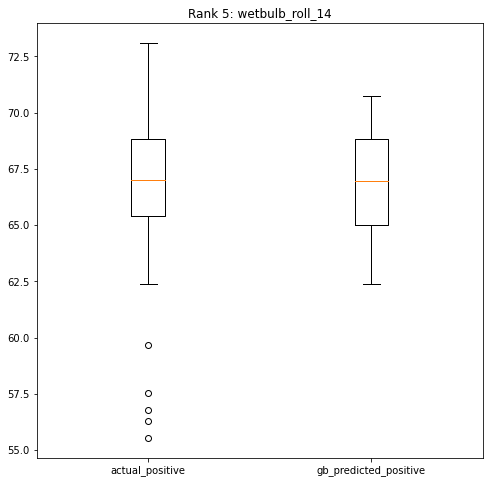

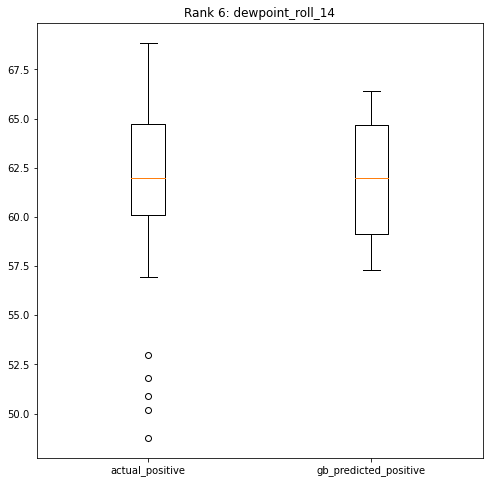

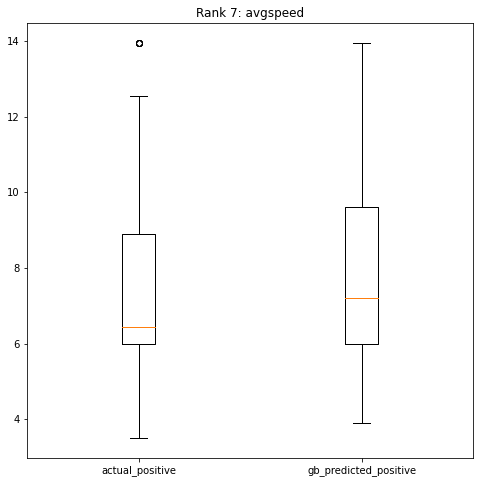

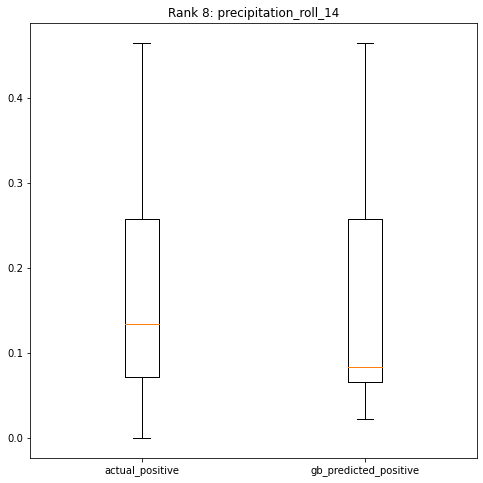

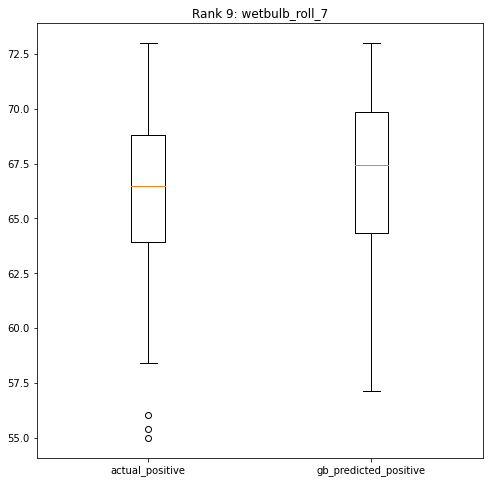

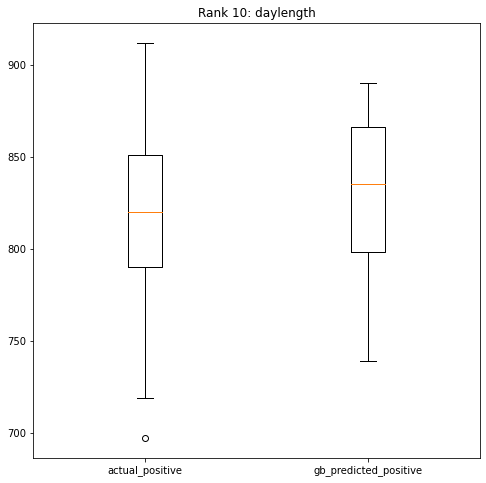

In [32]:
for i in range(10):
    fig, ax = plt.subplots(figsize=(8, 8))
    feature_name = gb_top10_feature_names[i]
    feat_act = act_positives[feature_name].tolist()
    feat_pred = gb_positives[feature_name].tolist()
    box = [feat_act, feat_pred]
    ax.set_title(f'Rank {i+1}: {feature_name}')
    ax.set_xticklabels(['actual_positive', 'gb_predicted_positive'])
    bp = ax.boxplot(box)

Visually, from the boxplots, the disparity is obvious especially for features like stnpressure_roll_14, mintemp_roll_14, wetbulb_roll_14, avgspeed, and daylength. 

### 3.2. Misclassification Analysis of the AdaBoost model
[top](#Contents)

In [33]:
# looking at the actual wnv but predicted by Adaboost model as not-wnv group
# similarly, we see some are actually predicted to by wnv by other models
misclass_df.iloc[:,-7:].loc[(misclass_df['wnv_present'] == 1) & (misclass_df['ab_wnv'] == 0)]

,wnv_present,gb_wnv,gb_probs,ab_wnv,ab_probs,xgb_wnv,xgb_probs
812,1.0,1.0,0.568726,0.0,0.499675,1.0,0.557727
6073,1.0,0.0,0.046084,0.0,0.492585,0.0,0.105449
2011,1.0,0.0,0.289691,0.0,0.499003,0.0,0.388058
5532,1.0,0.0,0.241363,0.0,0.496858,0.0,0.472037
7178,1.0,1.0,0.577468,0.0,0.499716,1.0,0.648907
6023,1.0,0.0,0.040799,0.0,0.497289,0.0,0.089025
977,1.0,0.0,0.145950,0.0,0.498023,0.0,0.213391
5994,1.0,0.0,0.040799,0.0,0.497289,0.0,0.089025
838,1.0,1.0,0.568726,0.0,0.499675,1.0,0.557727
6059,1.0,0.0,0.046084,0.0,0.492585,0.0,0.105449


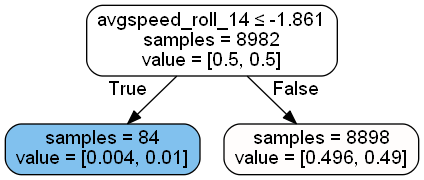

In [34]:
# plotting a particular tree diagram as an example of how the splits were done
# since AdaBoost is adaptive based on a single learner split, the diagram is not very instructive
# this is mostly shown for reference
sub_tree = gs_2.best_estimator_.named_steps['ada'].estimators_[37]  # tree no. 37 selected

dot_data = export_graphviz(
    sub_tree,
    out_file=None, filled=True, rounded=True,
    special_characters=True, feature_names=features,
    proportion=False, impurity=False,
)
graph = graph_from_dot_data(dot_data)
Image(graph.create_png(), width=200, height = 200)

In [35]:
# looking at characteristics of actual positives and predicted positives from AdaBoost model
# based on top10 features of our AdaBoost model
ada_top10_feature_names = ada_top10.index.tolist()
compare_misclass.loc[ada_top10_feature_names].iloc[:, [0,1,2,6,7,8]]

,act_post_1stQrt,act_post_median,act_post_3rdQrt,ab_post_1stQrt,ab_post_median,ab_post_3rdQrt
avgspeed_roll_7,6.500000,6.935714,8.046429,6.578571,7.621429,8.514286
mintemp,63.000000,69.000000,71.000000,61.000000,66.000000,69.000000
avgspeed,6.000000,6.450000,8.900000,6.450000,7.200000,9.600000
precipitation_roll_14,0.072429,0.134357,0.258214,0.072429,0.103679,0.258214
dewpoint_roll_7,59.071429,63.071429,65.642857,57.642857,62.928571,65.928571
dewpoint_roll_14,60.107143,62.000000,64.750000,58.000000,61.785714,64.678571
wetbulb_roll_7,63.928571,66.500000,68.785714,63.857143,66.142857,68.428571
month_peak,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
daylength,790.000000,820.000000,851.000000,780.000000,817.000000,835.000000
mintemp_roll_14,63.214286,64.500000,67.357143,62.071429,64.500000,66.642857


Looking at just the top10 important features, the IQR characteristics were slightly different for the top few features compared to the actual IQR:
- mintemp: actual IQR = (25% = 63, 50% = 69, 75% = 71) whereas predicted IQR = (61, 66, 69) with the predictions' IQR distribution shifted leftwards compared to the actual IQR distribution
<br>

- avgspeed_roll_7: actual IQR = (6.5, 6.936, 8.046) whereas predicted IQR = (6.579, 7.621, 8.514) with the predictions' IQR distribution included datapoints with high 7-day rolling average speed
<br>

- avgspeed: the predictions' IQR distribution shifted rightwards compared to the actual IQR distribution
<br>

- precipitation_roll_14: the predictions' IQR distribution included more datapoints in the lower end of the distribution such that the median was significantly lower compared to the actual median
<br>

- dewpoint_roll_7: the predictions' IQR distribution shifted leftwards compared to the actual IQR distribution
<br>

- daylength: the predictions' IQR distribution shifted leftwards compared to the actual IQR distribution
<br>

- avgtemp: the predictions' distributions probably included more datapoints in the 25th-50th quartile such that the median and 75th percentile decreased

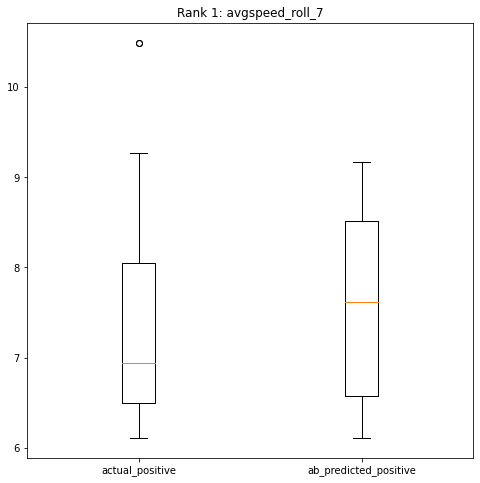

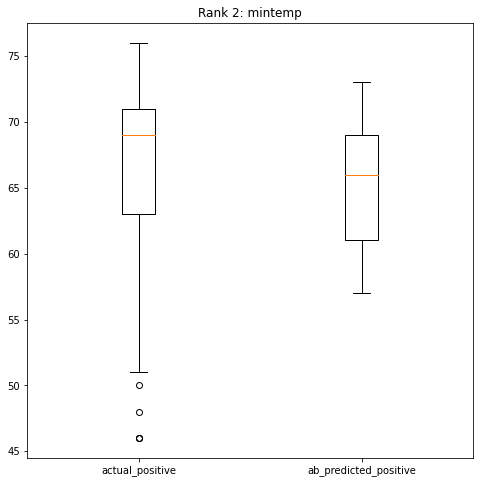

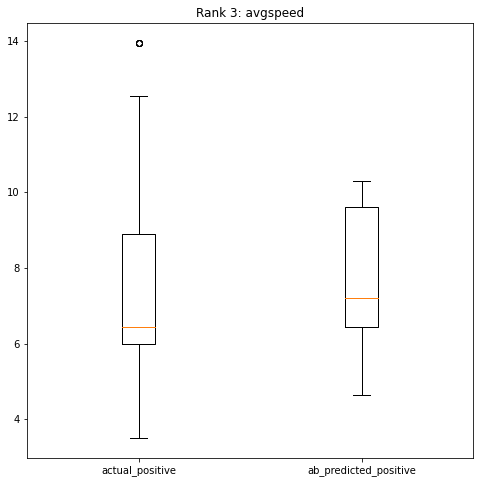

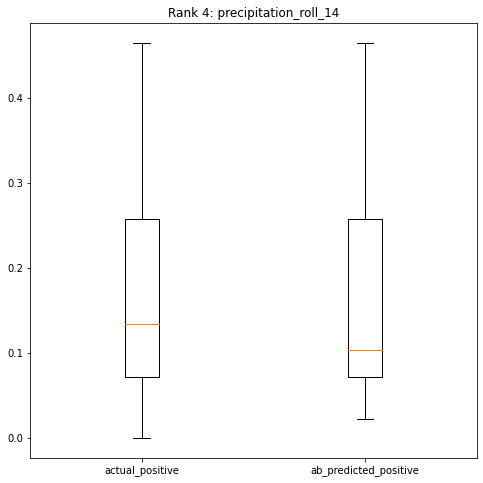

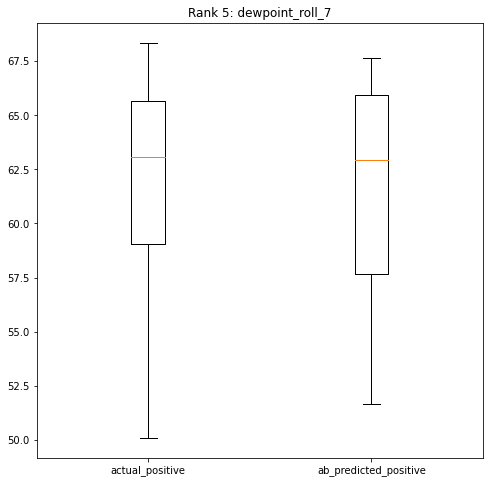

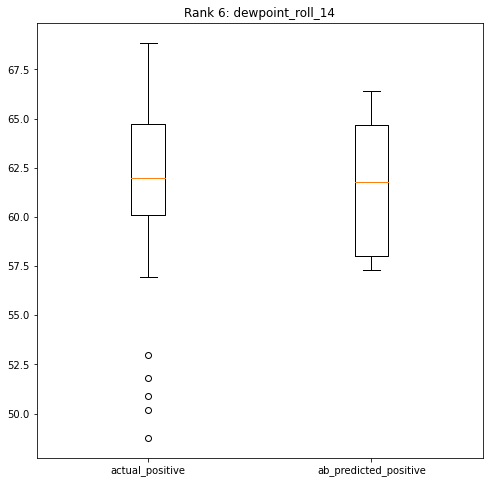

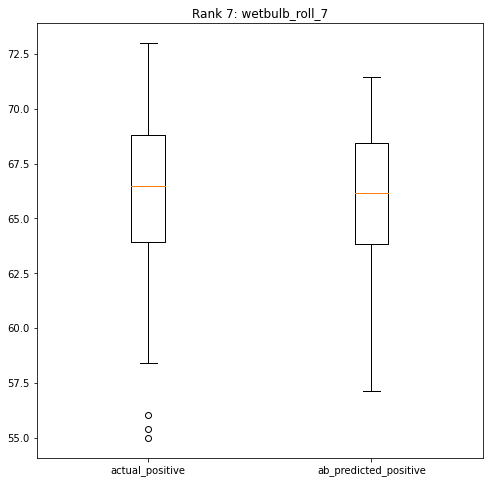

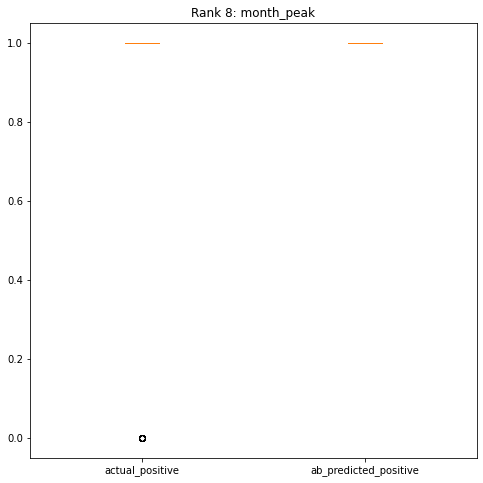

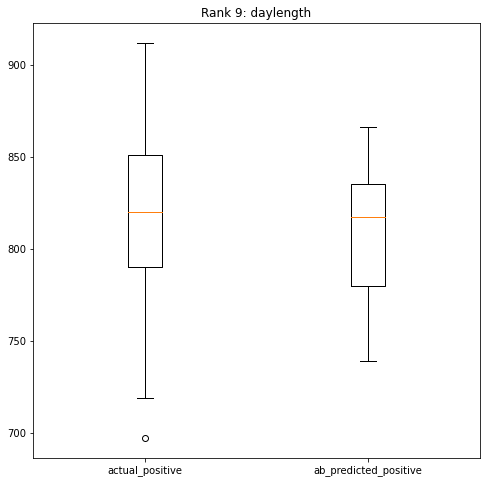

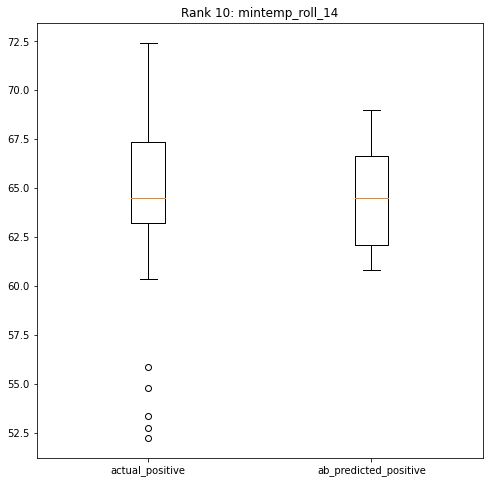

In [36]:
for i in range(10):
    fig, ax = plt.subplots(figsize=(8, 8))
    feature_name = ada_top10_feature_names[i]
    feat_act = act_positives[feature_name].tolist()
    feat_pred = ab_positives[feature_name].tolist()
    box = [feat_act, feat_pred]
    ax.set_title(f'Rank {i+1}: {feature_name}')
    ax.set_xticklabels(['actual_positive', 'ab_predicted_positive'])
    bp = ax.boxplot(box)

For the AdaBoost model, the disparity was obvious for mintemp, avgspeed, dewpoint_roll_14, daylength and avgtemp.

### 3.3. Misclassification Analysis of the Extreme GradientBoost model
[top](#Contents)

In [37]:
# looking at the actual wnv but predicted by Adaboost model as not-wnv group
# However, we see that the other models mostly failed to predict these as well
misclass_df.iloc[:,-7:].loc[(misclass_df['wnv_present'] == 1) & (misclass_df['xgb_wnv'] == 0)]

,wnv_present,gb_wnv,gb_probs,ab_wnv,ab_probs,xgb_wnv,xgb_probs
6073,1.0,0.0,0.046084,0.0,0.492585,0.0,0.105449
2011,1.0,0.0,0.289691,0.0,0.499003,0.0,0.388058
5532,1.0,0.0,0.241363,0.0,0.496858,0.0,0.472037
6023,1.0,0.0,0.040799,0.0,0.497289,0.0,0.089025
977,1.0,0.0,0.145950,0.0,0.498023,0.0,0.213391
5994,1.0,0.0,0.040799,0.0,0.497289,0.0,0.089025
6059,1.0,0.0,0.046084,0.0,0.492585,0.0,0.105449
5717,1.0,0.0,0.236128,0.0,0.496746,0.0,0.467158
2094,1.0,0.0,0.173896,0.0,0.495992,0.0,0.256429
8187,1.0,0.0,0.137863,0.0,0.495581,0.0,0.342171


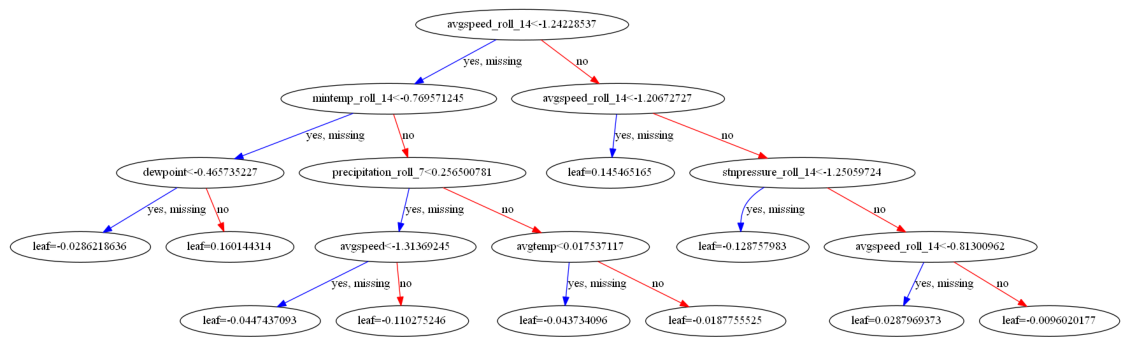

In [38]:
# plotting a particular tree diagram as an example of how the splits were done
xgb_model = gs_3.best_estimator_.named_steps['xgb']

# specify the feature names
xgb_model.get_booster().feature_names = features.tolist()

fig, ax = plt.subplots(figsize=(20,20))

plot_tree(xgb_model, num_trees=37, ax=ax);  # specify tree no. 37 to be shown

In [39]:
# looking at characteristics of actual positives and predicted positives from Extreme GradientBoost model
# based on top10 features of our XGB model
xgb_top10_feature_names = xgb_top10.index.tolist()
compare_misclass.loc[xgb_top10_feature_names].iloc[:, [0,1,2,9,10,11]]

,act_post_1stQrt,act_post_median,act_post_3rdQrt,xgb_post_1stQrt,xgb_post_median,xgb_post_3rdQrt
month_peak,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
trap_wnv_traps,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
daylength,790.000000,820.000000,851.000000,780.000000,835.000000,866.000000
dewpoint_roll_14,60.107143,62.000000,64.750000,58.000000,61.250000,64.428571
wetbulb_roll_14,65.428571,67.000000,68.821429,63.250000,66.750000,68.214286
species_wnv_species,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mintemp_roll_14,63.214286,64.500000,67.357143,62.071429,64.285714,66.642857
wetbulb_roll_7,63.928571,66.500000,68.785714,63.857143,67.428571,68.785714
dewpoint_roll_7,59.071429,63.071429,65.642857,57.642857,62.928571,65.642857
avgtemp,73.000000,76.500000,79.500000,73.000000,76.500000,80.000000


Looking at just the top10 important features, similar to the Adaboost model, the IQR characteristics were slightly different for the top few features compared to the actual IQR:
- daylength: actual IQR = (25% = 790, 50% = 820, 75% = 851) whereas predicted IQR = (780, 835, 866) with the predictions' IQR distribution included some points in the lower end of the distribution while adding much more points at the upper end of the distribution resulting in the 'stretching' of the predictions' distribution compared to the actual
<br>

- dewpoint_roll_14: actual IQR = (60.107, 62, 64.75) whereas predicted IQR = (58, 61.25, 64.429) with the predictions' IQR distribution included points in the lower end of the distribution resulting in the leftwards shift as well as a longer left tail
<br>

- wetbulb_roll_14: simiarly, the predictions IQR distribution included points in the lower end resulting in a slight leftwards shift and a longer left tail. actual IQR = (65.429, 67, 68.821), predicted IQR = (63.25, 66.75, 68.214)
<br>

- mintemp_roll_14: likewise, the predictions IQR distribution included points in the lower end resulting in a slight leftwards shift. actual IQR = (63.214, 64.5, 67.357), predicted IQR = (62.071, 64.286, 66.643)
<br>

- dewpoint_roll_7: actual IQR = (59.071, 63.071, 65.643) whereas predicted IQR = (57.643, 62.929, 65.643) with the predictions' IQR distribution included points in the lower end of the distribution resulting in a longer ('stretched') left tail

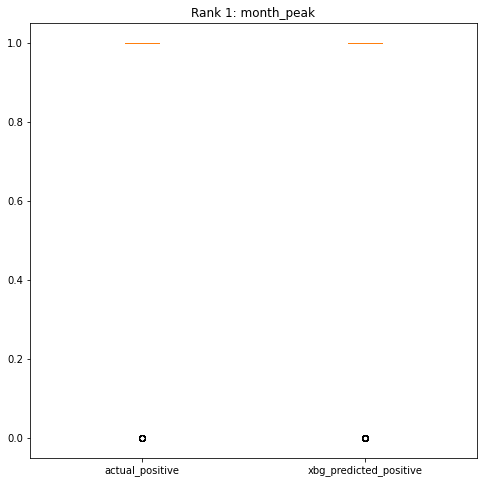

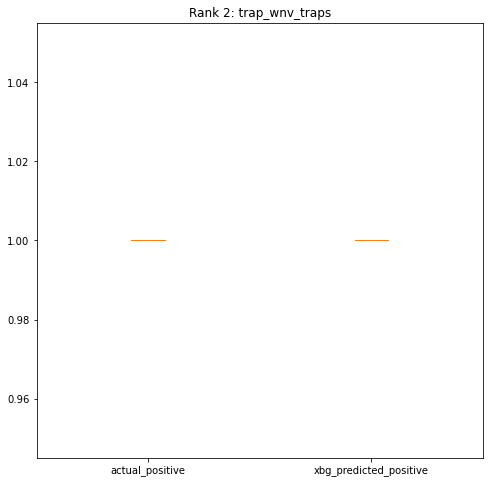

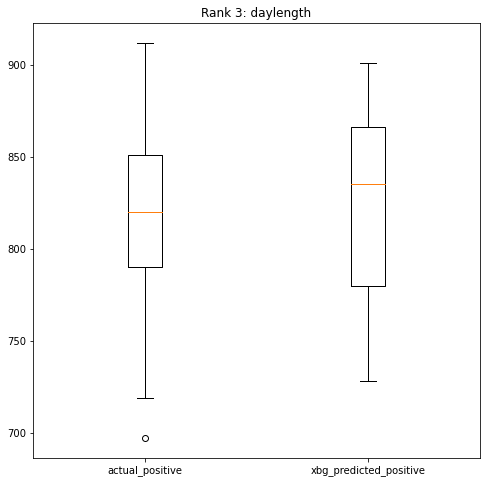

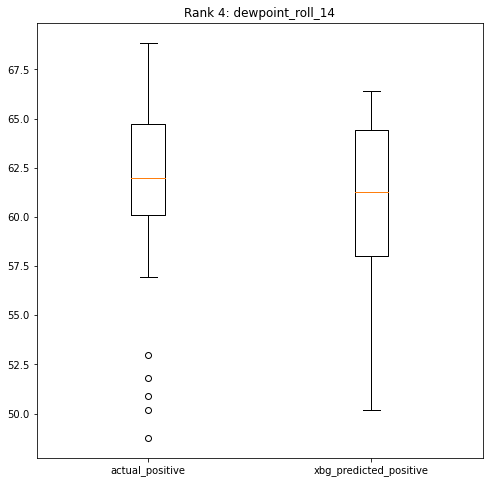

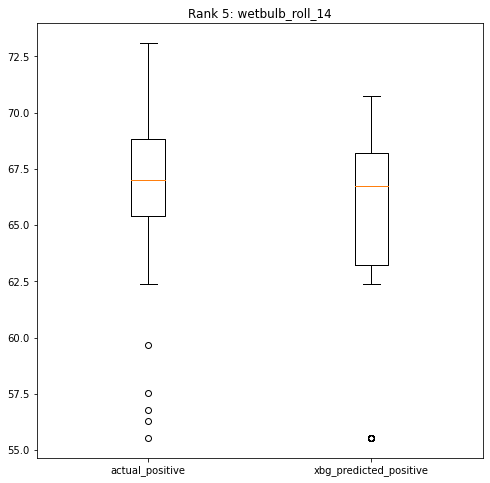

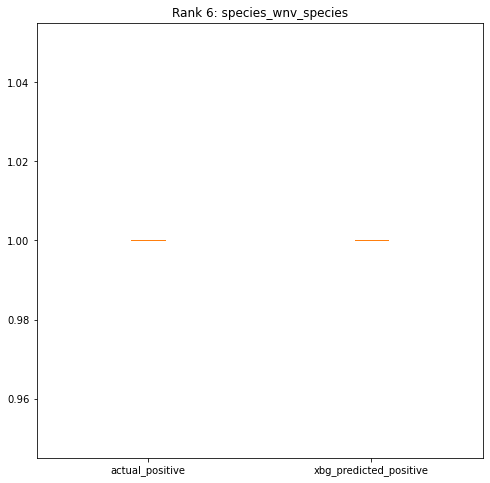

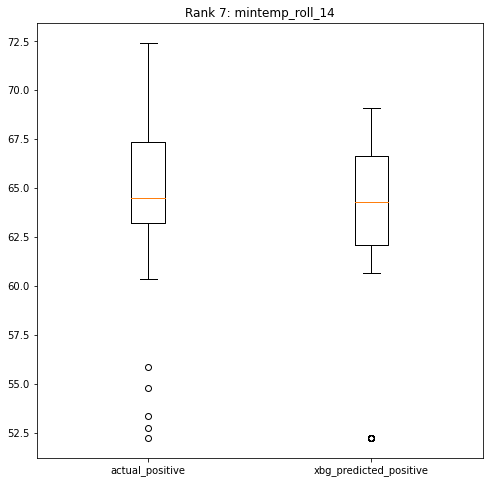

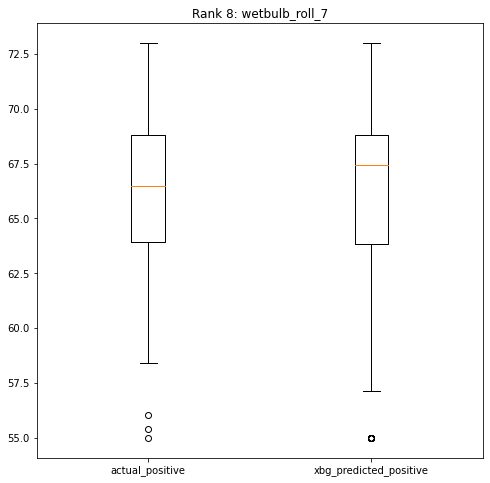

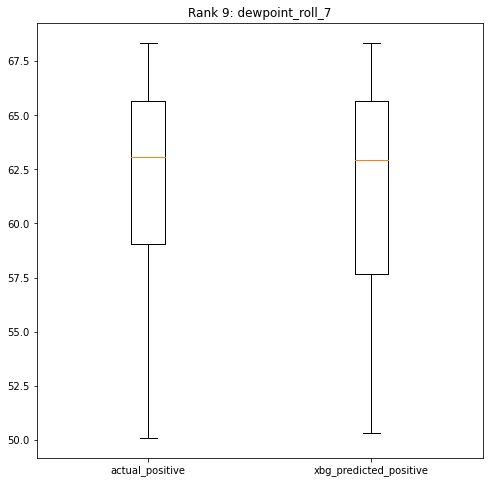

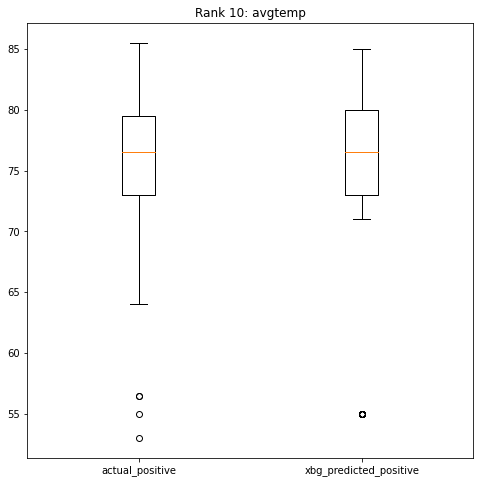

In [40]:
for i in range(10):
    fig, ax = plt.subplots(figsize=(8, 8))
    feature_name = xgb_top10_feature_names[i]
    feat_act = act_positives[feature_name].tolist()
    feat_pred = xgb_positives[feature_name].tolist()
    box = [feat_act, feat_pred]
    ax.set_title(f'Rank {i+1}: {feature_name}')
    ax.set_xticklabels(['actual_positive', 'xbg_predicted_positive'])
    bp = ax.boxplot(box)

Likewise, for the ExtremeBoost model, high disparity is observed in daylength, dewpoint_roll_14, wetbulb_roll_14, mintemp_roll_14, and avgtemp.

In conclusion, we see that our 3 boosting models (based on decision trees) were individually not perfect in their splits but have each done an admirable job in predicting wnv rates, yielding top 10 features which largely made sense and corroborated the factors identified by various studies done on WNV research. Additionally, when looking at each model's false negative predictions, we note in some cases the other models were actually able to predict them correctly (with the exception of our XGBoost model's false negative predictions, where the other models also mostly failed to predict these correctly).

With these findings, we are hopeful that a voting ensemble of our 3 models will give us an better overall prediction.

## 4. Production Model: creating a voting ensemble using our 3 models
[top](#Contents)

In [41]:
# specify each models best estimators

gb = make_pipeline(StandardScaler(),
                   SMOTE(sampling_strategy=0.9, 
                         k_neighbors=10,
                         random_state=42), 
                   GradientBoostingClassifier(loss='exponential',
                                              learning_rate=0.2,
                                              n_estimators=120,
                                              max_depth=4,
                                              random_state=42))

ada = make_pipeline(StandardScaler(),
                    SMOTE(sampling_strategy=0.65,
                          k_neighbors=13,
                          random_state=42),
                    AdaBoostClassifier(learning_rate=0.7,
                                       n_estimators=125,
                                       random_state=42))

xgb = make_pipeline(StandardScaler(),
                    SMOTE(sampling_strategy=0.85, 
                          k_neighbors=4,
                          random_state=42),
                    XGBClassifier(eval_metric='auc',
                                  learning_rate=0.14,
                                  min_child_weight=3,
                                  max_depth=4,
                                  max_delta_step=8,
                                  n_estimators=250,
                                  colsample_bytree=0.65,
                                  subsample=0.6,
                                  reg_alpha=0.09,
                                  reg_lambda=3,
                                  gamma=0.05,
                                  random_state=42))


# create the ensemble model based on Voting Classifier
ensemble = VotingClassifier(estimators=[('gb', gb), ('ada', ada), ('xgb', xgb)], 
                            voting='soft', 
                            n_jobs=-1,
                            verbose=True)

In [42]:
# looking at cross val AUC-ROC score on train split
auc_roc = cross_val_score(ensemble, X_train, y_train, scoring='roc_auc')
auc_roc

array([0.86457839, 0.82903195, 0.80057352, 0.83071545, 0.84322705])

In [43]:
# looking at AUC-ROC score on val set
# roc-auc score on val set was similar to the rest of the 3 individual models
ensemble.fit(X_train, y_train)
vote_predict = ensemble.predict_proba(X_val)[:,1]
roc_auc_score(y_val, vote_predict)

0.8628475487839712

In [44]:
# confusion matrix for our voting classifier
confusion_matrix(y_val, ensemble.predict(X_val))

array([[1902,  432],
       [  32,   91]], dtype=int64)

In [45]:
# voting classifier classification report
print(classification_report(y_val, ensemble.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.98      0.81      0.89      2334
         1.0       0.17      0.74      0.28       123

    accuracy                           0.81      2457
   macro avg       0.58      0.78      0.59      2457
weighted avg       0.94      0.81      0.86      2457



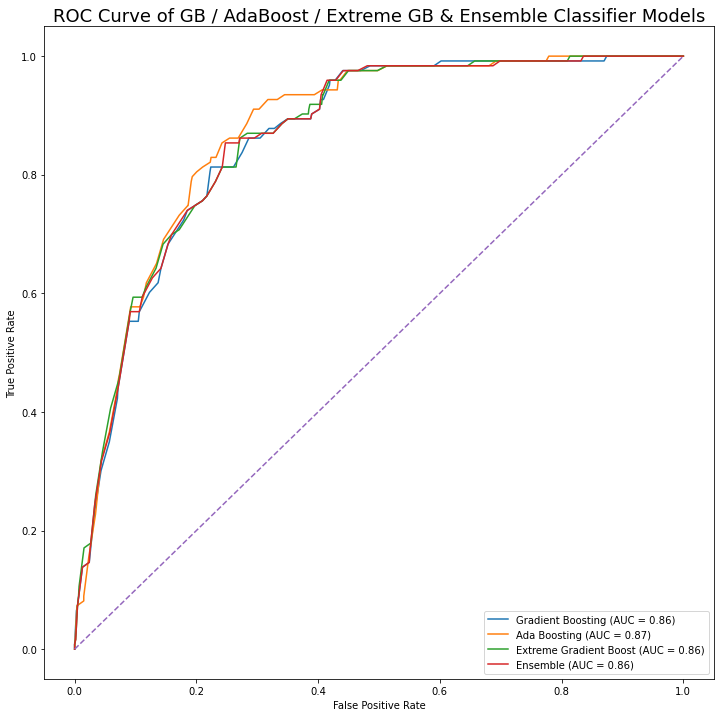

In [46]:
# adding our ensemble model into the ROC AUC plot
figure = plt.figure(figsize=(12,12))
ax = plt.gca()
Gboost_plot = plot_roc_curve(gs_1, X_val, y_val, name=grid_dict[0], ax=ax)
Adaboost_plot = plot_roc_curve(gs_2, X_val, y_val, name=grid_dict[1], ax=ax)
Xgb_plot = plot_roc_curve(gs_3, X_val, y_val, name=grid_dict[2], ax=ax)
ensemble_plot = plot_roc_curve(ensemble, X_val, y_val, name='Ensemble', ax=ax)
ax.plot(np.linspace(0, 1, 200),
        np.linspace(0, 1, 200),
        linestyle='--')
plt.title('ROC Curve of GB / AdaBoost / Extreme GB & Ensemble Classifier Models', fontsize=18)
plt.show()

Our ensemble model AUC turns out to be **0.86**, which is similar AUC scores of the individual models. Additionally, the recall is relatively high at **0.74**. Recall score is calculated as true positive / (false negative + true positive), where the denominator is essentially all actual positives. Recall score is what we would like to focus on when there is a high cost associated with having false negatives (i.e. in this case - predicting wrongly that an area has no WNV occurrences, which could potentially lead to a serious WNV outbreak not being contained in time). 

Let's finally train our ensemble model on the whole training set and predict on the test set:

In [47]:
# fitting our ensemble voting classifier on the whole train set
ensemble.fit(X, y)

VotingClassifier(estimators=[('gb',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('smote',
                                               SMOTE(k_neighbors=10,
                                                     random_state=42,
                                                     sampling_strategy=0.9)),
                                              ('gradientboostingclassifier',
                                               GradientBoostingClassifier(learning_rate=0.2,
                                                                          loss='exponential',
                                                                          max_depth=4,
                                                                          n_estimators=120,
                                                                          random_state=42))])),
                     

In [48]:
# generate predictions probabilities on test set
pred_prob_voting = ensemble.predict_proba(test_df)

In [49]:
# structure data for submission
pred_prob_voting_wnv = [prob[1] for prob in pred_prob_voting]

submit_voting = pd.DataFrame()
submit_voting['Id'] = id_series
submit_voting['WnvPresent'] = pred_prob_voting_wnv

In [50]:
submit_voting.to_csv('../submissions/voting_model.csv', index=False)

In [51]:
# out of curiosity, we submitted scores for each model for kaggle as well
# gb model
best_model_gb = gs_1.fit(X, y)
pred_prob_gb = best_model_gb.predict_proba(test_df)
pred_prob_gb_wnv = [prob[1] for prob in pred_prob_gb]

test_submit_gb = pd.DataFrame()
test_submit_gb['Id'] = id_series
test_submit_gb['WnvPresent'] = pred_prob_gb_wnv

test_submit_gb.to_csv('../submissions/gb_model.csv', index=False)

# ab model
best_model_ab = gs_2.fit(X, y)
pred_prob_ab = best_model_ab.predict_proba(test_df)
pred_prob_ab_wnv = [prob[1] for prob in pred_prob_ab]

test_submit_ab = pd.DataFrame()
test_submit_ab['Id'] = id_series
test_submit_ab['WnvPresent'] = pred_prob_ab_wnv

test_submit_ab.to_csv('../submissions/ab_model.csv', index=False)

# xgb model
best_model_xgb = gs_3.fit(X, y)
pred_prob_xgb = best_model_xgb.predict_proba(test_df)
pred_prob_xgb_wnv = [prob[1] for prob in pred_prob_xgb]

test_submit_xgb = pd.DataFrame()
test_submit_xgb['Id'] = id_series
test_submit_xgb['WnvPresent'] = pred_prob_xgb_wnv

test_submit_xgb.to_csv('../submissions/xgb_model.csv', index=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.8s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.9min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   48.2s finished
C:\Users\robby\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


### 4.1. Kaggle Scoring
[top](#Contents)

We submitted 4 scores onto Kaggle, including the 3 individual models, as well as our ensemble model to observe their predictive performance. Individually, the models scored in the range of 0.69 - 0.72, and somewhat surprisingly, our Extreme GradientBoost model did the worst of the 3. However, our voting model did much better with a score of **0.75**, which was a significant improvement over all 3 individual models. This suggests that the models may have had sufficient variance such that they were able to cover for each other's shortcomings. 

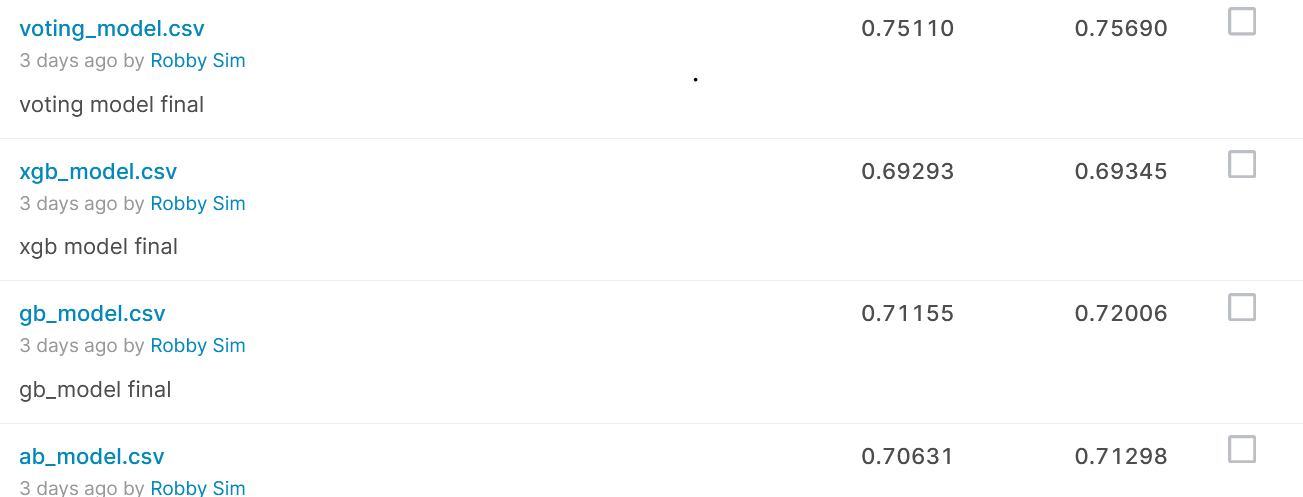

With our model trained and in place to perform predictions, the next step would be to determine how best it can be deployed to aid the city's administration in performing targeted vector control measures (e.g. spraying) in the city of Chicago. 

The next section details how spraying is typically being carried out as an effective form of vector control.

## 5. Overview of Spraying Control Measures
[top](#Contents)

There are currently no effective treatments for WNV, and the prevention of disease primarily relies on pest management programmes and control measures, such as the application of pesticides to be in place.

### 5.1. Efficacy of Spraying
[top](#Contents)

From our earlier visual exploration of the spray dataset and its effect on reducing WNV rates using `folium`, due to the lack of relevant trap data immediately before and after spraying a particular area, we were not able to conclusively state that spraying was able to reduce the number of positive WNV cases in an area. Nonetheless, based on the limited data that was available, we could still observe that spraying was able to effectively reduce the adult mosquito population, and likely the number of WNV positive mosquitoes as well.

As cited by a paper titled *Reducing West Nile Virus Risk Through Vector Management*, published by the Journal of Medical Entomology, several studies have also illustrated the effectiveness of spraying aerial adulticide as a reactionary control measure against WNV outbreaks:

### 5.2. Reactionary Control Measures
[top](#Contents)

1. **Sacramento-Yolo Mosquito and Vector Control District (2005):** Applications of adulticide were conducted on 3 consecutive nights in 2 treatment areas and the results indicated a 75% reduction of Culex pipens and a 48.7% reduction in Culex tarsalis population in the treated area compared to the untreated area. Additionally, human WNV case incidence was significantly lower in the treated area compared to the untreated area, with the odds of human WNV infections approximately 6 times higher in the untreated area compared to equal odds before the treatment. 


2. **Texas WNV outbreak in 2012:** Spraying was conducted 3 times between 16 Aug to 2 Sep 2012 and it was found that WNV neuroinvasive disease incidence decreased from 7.31/100,000 before treatment to 0.28/100,000 after treatment in the treated area.


3. **Chicago WNV outbreak in 2005:** 2 treatments applied 7 days apart during the week of 31 Jul and 7 Aug reduced adult mosquito abundance by 54% in the treated areas. During this same period, mosquito abundance actually increased by 153% in the untreated areas. Furthermore, a second round of 2 treatments in the later weeks of Aug 2005 resulted in a 29% reduction in abundance compared to before the treatments. 

While the above showed the reactionary effects (i.e. reaction after a WNV outbreak) of spraying, the same paper also highlights studies which look into proactive preventive measures - preventing the WNV transmission intensity from even reaching a level that produce outbreaks of human disease.

### 5.3. Proactive Control Measures
[top](#Contents)

1. **Atlanta:** Larvicides was applied to catch basins in urban park areas over the course of 2 seasons and resulted in  more than 90% decrease in larval/pupal production in the catch basins. 

2. **Southern California:** In the first 2 seasons, limited reactive aerial spraying was noted to be insufficient to reduce vector mosquito abundance, WNV infection rates in mosquitoes or spread of WNV transmission. However, in the third year of the study, when intensive spraying was done at the first detection of WNV in mosquitoes which continued weekly, there was an average of 61% reduction in vector abundance and also associated reductions in WNV infection rates. 

3. **Sacramento (2007):** In late Jul 2007, WNV infection rates in Culex tarsalis and pipiens mosquitoes had exceeded levels of concern established by the California Department of Health which lead to spraying to a 215 sq km area each day for 3 consecutive days. This resulted in a 57% and 40% reduction in tarsalis and pipiens abundance respectively. Additionally, the WNV infection rate in declined by 77% and 21% in tarsalis and pipiens mosquitoes respectively during the 3 days following the treatments compared to the previous 3 days.


### 5.4. Reactive vs Proactive approach to vector control
[top](#Contents)

The above literature suggests that spraying, be it reactive or preventive, is indeed a useful means of controlling the WNV carrier mosquito population, and consequently the WNV infection rates. **Reactive efforts** usually start after most human infections have occurred and the outbreak is already starting to decline naturally. The measures implemented to stop an ongoing WNV outbreak can still be effective provided that they are sufficiently intensive. However, these are usually expensive in terms of the cost of control measures as well as economic costs resulting from human infections that have already occurred. 

A more effective approach would thus be **proactively** establishing surveillance systems for monitoring mosquito numbers and WNV infection rates in mosquito vectors, as well as the appropriate response plans to intensify control efforts when particular threshold levels are met. Some factors that influence these threshold levels could include counts of dead birds, temperature, rainfall and human case surveillance, among others. These factors, coupled with localized knowledge of vector hotspots as well as experiences with previous outbreaks can lead to better effective management of WNV transmission. The authors suggest that due to the localized nature of vector developments, there is no one-size-fit-all approach in mosquito control, and hence each state/county should implement their own proactive mosquito control management based on localized historical data.

Our model, which has been trained on historical Chicago data is hence an example of the latter proactive approach, as we are able to predict the locations that are likely to have WNV occurrences based on weather data and other historical factors, and perform targeted spraying of these specific areas during months when virus-transmission rates are high. In the subsequent analysis, we will assume that spraying has **100% efficacy in completely eliminating any occurrence of human WNV cases in the sprayed areas**. This is in line with the findings from an earlier study done, which showed that after a 2005 emergency aerial spray in Sacramento County, it was observed that there were no incident human cases in a treated area, compared to 18 cases in an untreated area (which served as the control).

### 5.5. Historical costs of vector control
[top](#Contents)

The same literature also examine some of the direct costs of spraying or control WNV outbreaks which we can draw reference from:

1. **New York State, city and 4 counties (1999)**: In its first outbreak response to WNV, the state, city and 4 counties spent more than USD 14 million on protective measures such as mosquito control from late August through October.

2. **St. Tammany Parish (Louisiana - 2002)**: Additional mosquito control activities during the 2002 WNV outbreak cost USD 1.7 million over their usual USD 2 million budget.

3. **Sacremento (2005)**: The district spent USD 700,000 on aerial ULV applications alone in response to the 2005 WNV outbreak. 

4. **Dallas County (2012)**: Similarly, aerial ULV applications during the 2012 outbreak cost approximately USD 1.7 million.

It is worth noting that in these 4 instances the measures were reactionary, typically in response to an occurring outbreak and that the costs were exorbitantly high just to control it.

## 6. Cost Benefit Analysis & Recommendations
[top](#Contents)

In light of our predicted results for WNV occurrences in the various traps spread throughout Chicago (in the test dataset), our aim is to recommend the extent and frequency of spraying to be performed. This will be achieved by weighing the potential costs incurred and benefits derived from spraying the affected areas.

### 6.1. Human costs of WNV Disease
[top](#Contents)

This [paper](https://www.cmmcp.org/sites/g/files/vyhlif2966/f/uploads/cost_of_wnv_disease_among_hospitalized_patients.pdf) examines the initial and long-term costs of patients hospitalized with WNV disease which includes the lost-productivity from 80 patients hospitalized with WNV disease in Colorado in 2003. Based on past data, approximately 80% of WNV human infections are asymptomatic while symptomatic persons experience an acute systemic febrile illness, known as WNV fever or non-nueroinvasive disease which includes headache or rash. However, less than 1% will develop a more serious neuroinvasive disease which manifests as encephalitis (infection of the brain), meningitis (inflammation of the protective membranes covering the brain and spinal cord) or acute flaccid paralysis (AFP: weakness or paralysis with reduced muscle tone). 

Most patients with WNV meningitis or non-neuroinvasive disease recover completely, but fatigue and malaise can linger for weeks or months. Patients who recover from encephalitis or AFP often  have residual neurologic deficits with a higher than 10% chance of fatality. The associated costs (median with range) are summarized in the table below:


| Referenced   to 2012 USD                       | Fever (N=18)             | Meningitis (N=19)          | Encephalitis (N=16)          | AFP (N=27)                     |
|------------------------------------------------|--------------------------|----------------------------|------------------------------|--------------------------------|
| **Direct costs:**                                  |                          |                            |                              |                                |
| Inpatient hospital costs                       | 4,467       (419-23,374) | 7,261       (337-13,633)   | 15,136       (3,734-207,303) | 20,774       (5,066-264,176)   |
| Lost productivity                              | 328       (92-2,729)     | 682       (68-1,592)       | 1,380       (113-307,871)    | 2,136       (232-145,750)      |
| Total direct initial costs                     | 4,617       (538-24,010) | 7,942       (1,057-14,569) | 20,105       (3,965-324,167) | 25,117       (5,385 - 283,381) |
|                                                |                          |                            |                              |                                |
| **Long-term costs:**                               | **Fever (N=12)**             | **Meningitis (N=11)**          | **Encephalitis (N=5)**           | **AFP (N=10)**                     |
| Medical appointments                           | 109       (0-677)        | 0       (0-851)            | 495       (0-17,160)         | 3,671       (452-12,093)       |
| Additional care costs                          | 0       (0-8,900)        | 0       (0)                | 334       (0-10,013)         | 278       (0-6,119)            |
| Medicines & equipment                          | 72       (0-5,320)       | 33       (0-1,305)         | 109       (0-1,964)          | 590       (106-427,028)        |
| Lost productivity                              | 1,180       (0-39,760)   | 10,363       (0-258,592)   | 0       (0-5,596)            | 6,771       (0-143,033)        |
| Total long-term costs                          | 2,271       (0-41,401)   | 10,556       (0-260,748)   | 8,055       (0-23,693)       | 22,628       (624-439,945)     |
|                                                |                          |                            |                              |                                |
| Simple   overall median       (not from paper) | 6,888                    | 18,498                     | 28,160                       | 47,745                         |
<br>

Persons diagnosed with AFP incurred the most expense due to the severity of AFP, which often results in paresis (partial paralysis) to extensive paralysis, including neuromuscular respiratory failure, which are often permanent effects. Lost productivity was notably lower for encephalitis cases because encephalitis tended to occur in older individuals who were retired and thus incurred no lost productivity in the study. <br>


### 6.2. Annual Cost
[top](#Contents)

The costs incurred due to spraying are two-fold:

- Contractual price for spraying (depends on frequency, area of coverage, and mode of delivery) for mosquito control

- Damage to the non-target organisms, humans, and the environment as a result of spraying

**Assumptions Made**

- Chicago has a total land area of **601.6** square kilometers

- Unit cost of spraying on truck mounted ULV per linear mile: USD 50 (based on below rate for a contract tender in 2016). This translate to about USD 28.6 per linear km. As this was based on a contract tender in 2016, we adjusted the figure upwards to account for inflation to year 2020 and arrived at a rate of USD 35 per linear km.  

- Additionally, back-pack ULV costs USD 190 per 1/4 linear mile which translates to about USD 560 per linear km after inflation. 

- [Chicago](https://www.chicago.gov/city/en/depts/cdot/provdrs/street.html) has more than 4,000 miles of streets and 1,900 miles of alleys which translates to 6,450 km of streets and 3050 km of alleys. 

- To fully spray Chicago using trucks and back-pack ULV to reach places not accessible by streets (parks, surroundings of water bodies, etc), we assume that the streets will be fully used while the alleys needed to cover the remaining area are about 40% of the 3,050 km of alleys. 

- Thus, the full cost to cover spraying the entire Chicago city once is about USD 1 million. 

- The spraying will be applied at least 4 times during the mosquito season (Aug/Sep), as a one-time application typically lasts about 14-21 days. We will take the mosquito season to last 2 mosquito breeding cycles.

- Previous risk assessments using exposure scenarios for pyrethrins (the typical pesticides used in spraying) that exceed what is used in a typical spraying scenario have risks that are below Environmental Protection Agency levels of concern. As such, **the ecological and human impact of spraying is taken to be 0**.

**Total Cost**

- With the above simplifying assumptions, the overall cost of spraying to cover the entire city of Chicago is determined to be **USD 4 million**.

**Chicago Department of Public Health Budget**

- [2019 overall public health budget](https://www.chicago.gov/content/dam/city/depts/obm/supp_info/2019Budget/2019BudgetOverview.pdf) was USD 35 million

**Adult Mosquito Fogging Pricing (City of Burleson - Texas, 2016)**
<br>
[Source](https://destinyhosted.com/burledocs/2016/CCREG/20160620_260/1214_BURL%20MosquitoContract%202016%20(2).pdf)
<div>
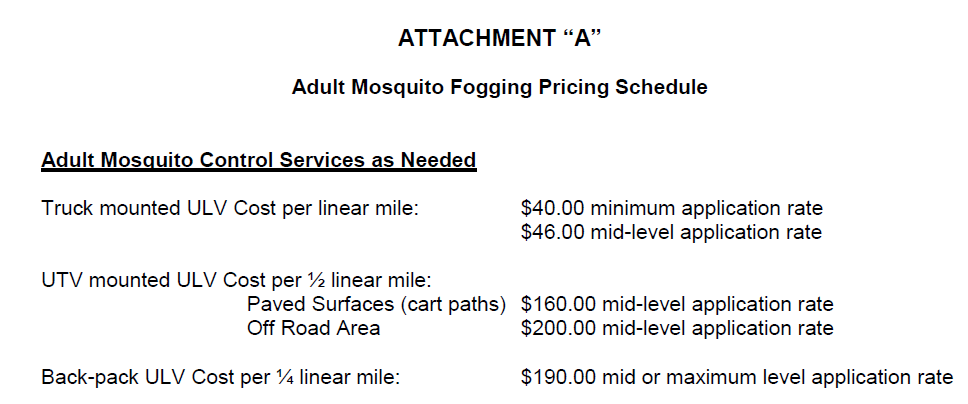



### 6.3. Annual Benefit
[top](#Contents)

The benefits to be derived from spraying mainly comprise the following:

- Avoidance of medical treatment costs
- Avoidance of productivity loss due to hospitalization of patients with WNV

**Assumptions Made**

- Number of cases of WNV per year is about **35**, based on the average number of wnv cases from 2012-2018. (see chart from Part 1 of the notebook)

- The overall median costs due to treatment and lost of productivity of a WNV patient, based on a weighted average of the table above, is estimated to be **USD 28,000**.

**Total Benefits**

While it is unethical to create a control and treatment group to verify the true benefits, recall that in the Sacramento-Yolo Mosquito and Vector Control District (2005) study, odds of wnv infections was 6 times higher in the untreated area compared to the treated area. Hence, based on a simple calculation, should there be no spraying in Chicago city, the number of cases of WNV could potentially reach 210 cases per annum (35 average cases x 6). Translating this to benefits, we assume that the total benefits to be USD 6 million (total estimated cost incurred if no intervention) - USD 1 million (total cost incurred with intervention) = **USD 5 million**

Thus, based on the above calculations and weighing the total costs/benefits, current vector management program in Chicago is assumed to derive a net benefit of **USD 1 million per year**. 

### 6.4. Recommendations
[top](#Contents)

Recall that the city's public health budget for 2019 was USD 36 million. The assumed USD 4 million spent per year on spraying constitutes more than 10% of the annual budget and **might not be sustainable** given that the department will need to allocate funds for other uses in public health as well as other vector control approaches. 

Additionally, we also note that the above calculations on the benefits may severely underestimate the true number of cases that are prevented by the spray, as it is difficult to account for undiagnosed and unreported WNV cases. Pain and distress suffered by patients and their loved ones are also not easy to quantify in terms of monetary costs.

As such, we can use our model in the following manner: 
1. to feed relevant forecasted weather data and our engineered features into the model, and *proactively* perform spraying only on **mosquito hotspots that are predicted by our model to have a high likelihood of WNV positive occurrence**. This will achieve the biggest impact in terms of mosquito reduction. Given our model recall score of 0.74 and taking into account the number of false negatives (thus, the need for spraying after wnv traps are detected by current methods), we hope to reduce the cost of spraying by 30% initially, translating to further cost savings of **USD 1.2 million**. 
2. further assume that with our model prediction, we can drive the average wnv infection rates down by 50%, which will achieve an **additional benefit of USD 500,000 per annum** based on the reduced infection rate.   

**Overall, our model is able to deliver annual benefits of USD 1.7 million.** 

We also recommend the adoption of the complete, proactive vector management plan that was earlier touched upon, which relies on active monitoring and surveillance systems, with defined action plans for each threshold that is breached, combined with predictions generated by models based on forecasted weather variables. 

Other common prevention methods include identification of breeding sites, elimination or (if elimination is not possible) management of breeding sites. Individual household education is also essential to manage and control micro sites like tires, buckets, planters, pools, birdbaths, flowerpots or trash containers. 

Furthermore, recall in our model that we only have 1 feature that cannot be forecasted beforehand - `wnv_species`. All other features, especially weather features should be possible to have a decent and early forecast such that these can be used with our model. Is our model still workable when we drop `wnv_species`? We briefly tested this out and the answer is a decent affirmative with a slight loss in AUC, but huge increase in predictability and useablilty for the city of Chicago:

In [52]:
X = train.drop(['date', 'wnvpresent', 'nummosquitos', 'species_wnv_species'],
               axis=1)
y = train['wnvpresent']

In [53]:
test_df.drop(['species_wnv_species'], axis=1, inplace=True)

In [54]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=42)

In [55]:
# looking at cross val AUC-ROC score on train split
auc_roc = cross_val_score(ensemble, X_train, y_train, scoring='roc_auc')
auc_roc

array([0.85769925, 0.82773509, 0.81152836, 0.82373979, 0.84211777])

In [56]:
# looking at AUC-ROC score on val set
# roc-auc score on val set was similar to the rest of the 3 individual models
ensemble.fit(X_train, y_train)
vote_predict = ensemble.predict_proba(X_val)[:,1]
roc_auc_score(y_val, vote_predict)

0.8572655199559707

In [57]:
confusion_matrix(y_val, ensemble.predict(X_val))

array([[1884,  450],
       [  32,   91]], dtype=int64)

In [58]:
print(classification_report(y_val, ensemble.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.98      0.81      0.89      2334
         1.0       0.17      0.74      0.27       123

    accuracy                           0.80      2457
   macro avg       0.58      0.77      0.58      2457
weighted avg       0.94      0.80      0.86      2457



In [59]:
# fitting our ensemble voting classifier on the whole train set
ensemble.fit(X, y)

VotingClassifier(estimators=[('gb',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('smote',
                                               SMOTE(k_neighbors=10,
                                                     random_state=42,
                                                     sampling_strategy=0.9)),
                                              ('gradientboostingclassifier',
                                               GradientBoostingClassifier(learning_rate=0.2,
                                                                          loss='exponential',
                                                                          max_depth=4,
                                                                          n_estimators=120,
                                                                          random_state=42))])),
                     

In [60]:
# generate predictions probabilities on test set
pred_prob_voting = ensemble.predict_proba(test_df)

In [61]:
# structure data for submission
pred_prob_voting_wnv = [prob[1] for prob in pred_prob_voting]

submit_voting = pd.DataFrame()
submit_voting['Id'] = id_series
submit_voting['WnvPresent'] = pred_prob_voting_wnv

In [62]:
submit_voting.to_csv('../submissions/voting_model_drop_species.csv', index=False)

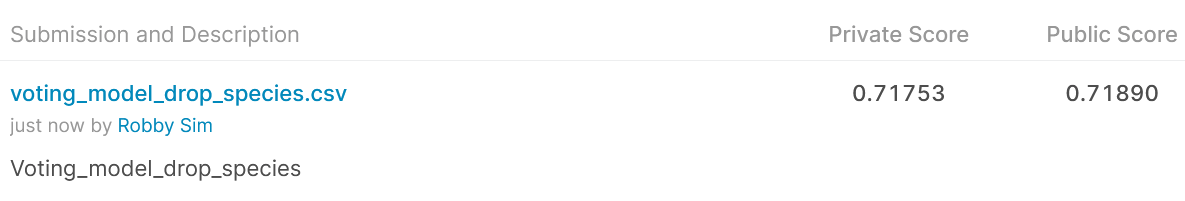

We see that our validation AUC-ROC score declined slightly from **0.863** to **0.857**, with the recall score remaining the same at **0.74**. On kaggle, the score dropped to **0.718** which is still decent in our opinion. We exchanged a slight drop in scoring with a model that can be fully used apriori which will help the city of Chicago implement a total proactive approach to vector and WNV management. 

## 7. Conclusions
[top](#Contents)

Our final `VotingClassifier` model which is fully predictive, comprises of an ensemble of`GradientBoostingClassifier`, `AdaBoostClassifier` and `XGBClassifier` boosting models achieved a validation AUC of **0.852** and recall of **0.74** on the validation dataset. Our submission to kaggle achieved an AUC score of **0.718**, indicating that our model achieved good success in separating the negative and positive class distributions, even in the unseen test dataset.

The model is able to aid the city of Chicago's administration in determining the hotspot locations to perform targeted spraying of pesticides as a proactive form of mosquito control, thereby reducing the costs of preventing WNV to a manageable level, while still adequately protecting its people from being afflicted by the potentially life threatening disease.

Future improvements to our model could involve the following:
- Incorporate other potentially relevant features such as counts of dead birds, proximity to water bodies  
- Obtaining more granular data to better account for the efficacy of spraying, e.g.
    - Regular daily trap testing data for a week prior and after spraying
    - Data for all traps within the spray areas
    - Data for sprayed areas that have historically high number of mosquitos to better observe the spray effect

## 8. References
[top](#Contents)

1. Costs of mosquito control (recurring treatment services)
    - https://www.homeadvisor.com/cost/environmental-safety/mosquito-control/#once
<br>    
   
   
2. Reducing West Nile Virus Risk Through Vector Management
    - https://www.cmmcp.org/sites/g/files/vyhlif2966/f/uploads/tjz083.pdf
<br>    
  
  
3. Economic Cost Analysis of West Nile Virus Outbreak, Sacramento County, California, USA, 2005    
    - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/pdf/09-0667_finalR.pdf
<br>    
 
 
4. Number of reported confirmed and probable cases of West Nile virus among Chicago residents by year, 2002-2012.
    - https://www.chicago.gov/content/dam/city/depts/cdph/statistics_and_reports/CDInfo_2013_JULY_WNV.pdf
<br>


5. Initial and Long-Term Costs of Patients Hospitalized with West Nile Virus Disease
    - https://www.cmmcp.org/sites/g/files/vyhlif2966/f/uploads/cost_of_wnv_disease_among_hospitalized_patients.pdf
<br>


6. Contract for Contingency Mosquito Fogging Services, City of Burleson, Texas, 2016
    - https://destinyhosted.com/burledocs/2016/CCREG/20160620_260/1214_BURL%20MosquitoContract%202016%20(2).pdf
    <br>
    
    
7. City of Chicago, 2019 Budget Overview
    - (https://www.chicago.gov/content/dam/city/depts/obm/supp_info/2019Budget/2019BudgetOverview.pdf)